# PART 1: 
## Analysis, Manipulation and Splitting of Data

In [1]:
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.2 MB/s eta 0:00:00


In [2]:
# Import necessary libraries

# data processing
import pandas as pd
import numpy as np

# tensors
import torch

# other
import json
import re

# sklearn
from sklearn.preprocessing import LabelEncoder

# hugging face dataset
from datasets import Dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import wandb
from kaggle_secrets import UserSecretsClient

# Load the API key from Kaggle's secrets
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")

# Set up the API key for wandb
wandb.login(key=wandb_api_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### 1.1 Importing the datasets

In [4]:
# Read a file containing a list of JSON objects

def load_json_list(file_name):
    data = []
    with open(file_name, 'r') as f:
        for line in f:
            try:
                dat = json.loads(line)
                # Avoid empty dictionaries
                if dat:
                    data.append(dat)
            except JSONDecodeError:
                pass

    return data

In [5]:
# Load audience and critics reviews from the Rotten Tomatoes dataset

audience_reviews = load_json_list('/kaggle/input/rotten-tomatoes-reviews/movie_reviews/audience_reviews_short.json')
critics_reviews = load_json_list('/kaggle/input/rotten-tomatoes-reviews/movie_reviews/critics_reviews_short.json')

In [6]:
# Read the CSV file into a pandas Dataframe

df_emotions = pd.read_csv('/kaggle/input/emotions-in-text/Emotion_final.csv')

### 1.2 Dropping unecessary information

In [7]:
# Extract rating and review text from audience reviews

data_audience = [{'rating': review['rating'], 'text': review['review']} 
                 for dat in audience_reviews if dat.get('reviews') for review in dat['reviews']]

print(data_audience[:5])

[{'rating': 3, 'text': 'It ended leaving u hanging'}, {'rating': 2.5, 'text': 'Good story. Dragged a little, but interesting.'}, {'rating': 5, 'text': 'Put this one in the plus column for M Night Shyamalan.'}, {'rating': 5, 'text': 'Very good movie. Kept us on the edge of our seat the whole time.'}, {'rating': 5, 'text': 'This movie definitely had alot of suspense, kept you guessing.  Definitely one of M. Night Shyamalan better movies along with Sixth sense.'}]


In [8]:
# Define a classifier function based on the rating score

classifier = lambda score: 1 if score >= 4.0 else 0 if score <= 1.5 else -1
print('Before', len(data_audience))

Before 19391


In [9]:
# Filter out neutral reviews and keep only text and sentiment columns

data_audience = [{'text': review['text'], 'sentiment': classifier(review['rating'])} 
                 for review in data_audience 
                 if classifier(review['rating']) != -1]

print('After removing neutral reviews', len(data_audience))
print(data_audience[:5])

After removing neutral reviews 14931
[{'text': 'Put this one in the plus column for M Night Shyamalan.', 'sentiment': 1}, {'text': 'Very good movie. Kept us on the edge of our seat the whole time.', 'sentiment': 1}, {'text': 'This movie definitely had alot of suspense, kept you guessing.  Definitely one of M. Night Shyamalan better movies along with Sixth sense.', 'sentiment': 1}, {'text': 'Oh no A movie I didn’t like. It was twisted and weird. The worst M. Night Shyamalan movie ever. This was 100% Bad', 'sentiment': 0}, {'text': "Great movie…..wasn't expecting that.", 'sentiment': 1}]


In [10]:
# Create a DataFrame for audience reviews
df_audience = pd.DataFrame(data_audience)
print(df_audience[:5])

                                                text  sentiment
0  Put this one in the plus column for M Night Sh...          1
1  Very good movie. Kept us on the edge of our se...          1
2  This movie definitely had alot of suspense, ke...          1
3  Oh no A movie I didn’t like. It was twisted an...          0
4               Great movie…..wasn't expecting that.          1


In [11]:
# Extract text, fresh, and rotten from critics_reviews

data_critics = [{'text': review.get('quote'), 
                 'fresh': review['isFresh'], 'rotten': review['isRotten']} 
                for dat in critics_reviews if dat.get('reviews') for review in dat['reviews']]

print('Number of samples', len(data_critics))

Number of samples 12867


In [12]:
# Keep only fresh reviews and transform fresh/rotten labels to sentiment labels (1=positive, 0=negative)
data_critics = [{'text': dat['text'], 'sentiment': int(dat['fresh'])} for dat in data_critics]
print(data_critics[:5])

[{'text': '[Shyamalan is] as strong a visual craftsman as ever, a master manipulator who toys with his audience with the winking acerbity of his idol Hitchcock. ', 'sentiment': 1}, {'text': 'There is only one thing worse than an M&#46; Night Shyamalan movie with a twist ending&#46; And that is one without a twist ending&#46; Feels like a faith-based movie trying to sneak in under a disingenuous wire&#46;', 'sentiment': 0}, {'text': 'Though at times you want it to deliver more on its promise&#44; the conclusion sticks the landing in ways few Shayamalan films of late have managed to', 'sentiment': 1}, {'text': 'While its questions about what we choose to put our faith in and why are as obvious as one late easy reveal&#44; Knock at the Cabin earns two firm beliefs&#58; in Shyamalan messing with vacations again&#44; and in Bautista at his best&#46;', 'sentiment': 1}, {'text': 'An artless film without the guts to bring the apocalyptic threat to life onscreen&#46;', 'sentiment': 0}]


In [13]:
# Create a DataFrame for critics reviews
df_critics = pd.DataFrame(data_critics)

In [14]:
# Remove special characters starting with '&' from the text
pattern = re.compile(r'\&\S+;')
df_critics['text'] = df_critics.text.apply(lambda x: pattern.sub(' ', str(x)))

# Remove extra spaces from the text
pattern_spaces = re.compile('\s{2,}')
df_critics['text'] = df_critics.text.apply(lambda x: pattern_spaces.sub(' ', str(x))).str.strip()

# Concatenate the critics and audience DataFrames
df_concat = pd.concat([df_critics, df_audience], ignore_index=True)

print(len(df_concat))

27798


### 1.3 Renaming the Columns

In [15]:
# Rename columns
reviews_df = df_concat.rename(columns={'text': 'sentence', 'sentiment': 'label'})
emotions_df = df_emotions.rename(columns={'Text': 'sentence', 'Emotion': 'label'})

# Print the updated DataFrame
print(reviews_df)
print(emotions_df)

                                                sentence  label
0      [Shyamalan is] as strong a visual craftsman as...      1
1      There is only one thing worse than an M Night ...      0
2      Though at times you want it to deliver more on...      1
3      While its questions about what we choose to pu...      1
4      An artless film without the guts to bring the ...      0
...                                                  ...    ...
27793  This movie saved the Shrek saga. A Spin-Off of...      1
27794  A great idea to tell the story of Puss in Boot...      0
27795  Dreamworks has been inconsistent for me. I lov...      1
27796  Honestly an unexpectedly really good movie. At...      1
27797  I'm glad that I was raised with that kind of a...      1

[27798 rows x 2 columns]
                                                sentence    label
0                                i didnt feel humiliated  sadness
1      i can go from feeling so hopeless to so damned...  sadness
2       

### 1.4 Manipulation of Labels

In [16]:
# Print the different values in the "label" column
unique_labels = emotions_df['label'].unique()
print(unique_labels)

['sadness' 'anger' 'love' 'surprise' 'fear' 'happy']


In [17]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label transformation
emotions_df['label'] = label_encoder.fit_transform(emotions_df['label'])

# Print the encoded labels
encoded_labels = emotions_df['label'].unique()
print(encoded_labels)

[4 0 3 5 1 2]


### 1.5 Data Splitting

In [18]:
# Training dataset
train_reviews =  reviews_df.sample(frac=0.7, random_state=42)
train_emotions = emotions_df.sample(frac=0.7, random_state=42)

# Testing dataset
test_reviews =  reviews_df.drop(train_reviews .index)
test_emotions = emotions_df.drop(train_emotions.index)

# Determine the count of records in the training and testing datasets.
print(f'The training dataset of movie reviews has {len(train_reviews)} records.')
print(f'The training dataset of emotion tweets has {len(train_emotions)} records.')
print(f'The testing dataset of movie reviews has {len(test_reviews)} records.')
print(f'The testing dataset of emotion tweets has {len(test_emotions)} records.')

The training dataset of movie reviews has 19459 records.
The training dataset of emotion tweets has 15021 records.
The testing dataset of movie reviews has 8339 records.
The testing dataset of emotion tweets has 6438 records.


### 1.6 Data preprocessing for text classification using BERT

In [19]:
# Transform dataset into a HG dataset
hg_train_sentiment = Dataset.from_pandas(train_reviews)
hg_test_sentiment = Dataset.from_pandas(test_reviews)
hg_train_emotion = Dataset.from_pandas(train_emotions)
hg_test_emotion = Dataset.from_pandas(test_emotions)

In [20]:
# Inspect the length of the dataset
print(f'The length of hg_train_data is {len(hg_train_sentiment)}.\n')

# check one review
hg_train_sentiment[0]

The length of hg_train_data is 19459.



{'sentence': 'Not a perfect movie but if you love movie making, Wolf of Wall Street and Boogie Nights this is a great pick',
 'label': 1,
 '__index_level_0__': 18168}

In [21]:
# Verify the data entry in a Pandas DataFrame
reviews_df.iloc[[18168]]

,sentence,label
18168,Not a perfect movie but if you love movie maki...,1


# PART 2: 
## BERT Fine-Tuning

### 2.1 Tokenenization

In [22]:
# Import necessary libraries

# tensorflow
import tensorflow as tf

# BERT
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline

# model performance evaluation
import evaluate

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [23]:
# Tokenizer from a pretrained model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Take a look at the tokenizer
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [24]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data["sentence"], 
                     max_length=32, 
                     truncation=True, 
                     padding="max_length")

# Tokenize the dataset for Sentiment Analysis
dataset_train_sent = hg_train_sentiment.map(tokenize_dataset)
dataset_test_sent = hg_test_sentiment.map(tokenize_dataset)

# Tokenize the dataset for Emotion Analysis
dataset_train_em = hg_train_emotion.map(tokenize_dataset)
dataset_test_em = hg_test_emotion.map(tokenize_dataset)

  0%|          | 0/19459 [00:00<?, ?ex/s]

  0%|          | 0/8339 [00:00<?, ?ex/s]

  0%|          | 0/15021 [00:00<?, ?ex/s]

  0%|          | 0/6438 [00:00<?, ?ex/s]

In [25]:
# Inspect the dataset
print(dataset_train_sent)
print(dataset_test_sent)

Dataset({
    features: ['sentence', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 19459
})
Dataset({
    features: ['sentence', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8339
})


### 2.2 Training Phase

In [26]:
# Load models
model_sent = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) #sentiment analysis
model_em = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)  #emotion analysis

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [27]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./sentiment_transfer_learning_transformer/",          
    logging_dir='./sentiment_transfer_learning_transformer/logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=2,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [28]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [29]:
# Train the model for Sentiment Analysis task

trainer = Trainer(
    model=model_sent,
    args=training_args,
    train_dataset=dataset_train_sent,
    eval_dataset=dataset_test_sent,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: mariateresadrp (mariateresadrp99). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230809_205105-m5qf1wex
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run colorful-capybara-40
wandb: ⭐️ View project at https://wandb.ai/mariateresadrp99/huggingface
wandb: 🚀 View run at https://wandb.ai/mariateresadrp99/huggingface/runs/m5qf1wex


Epoch,Training Loss,Validation Loss,Accuracy
1,0.382600,0.330348,0.910421
2,0.269600,0.390558,0.912340


TrainOutput(global_step=9730, training_loss=0.3260687362498394, metrics={'train_runtime': 585.4265, 'train_samples_per_second': 66.478, 'train_steps_per_second': 16.62, 'total_flos': 639984753281280.0, 'train_loss': 0.3260687362498394, 'epoch': 2.0})

In [30]:
# Train the model for Emotion Analysis task

trainer_em = Trainer(
    model=model_em,
    args=training_args,
    train_dataset=dataset_train_em,
    eval_dataset=dataset_test_em,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer_em.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.774200,0.441569,0.878689
2,0.362000,0.426464,0.891581


TrainOutput(global_step=7512, training_loss=0.5681202231377712, metrics={'train_runtime': 419.9252, 'train_samples_per_second': 71.541, 'train_steps_per_second': 17.889, 'total_flos': 494041637885184.0, 'train_loss': 0.5681202231377712, 'epoch': 2.0})

### 2.3 Evaluation and Inspection of Predictions

In [31]:
# Perform predictions using the 'trainer' object.
predict_test_sent = trainer.predict(dataset_test_sent)
predict_test_em = trainer_em.predict(dataset_test_em)

In [32]:
# Obtained model predictions as logits
logits_sent = predict_test_sent.predictions
logits_em = predict_test_em.predictions

# Inspect first 5 predicted probabilities
logits_sent[:5]

array([[ 1.963164 , -1.9271927],
       [ 1.821357 , -1.8584747],
       [ 1.3023396, -1.1597121],
       [-1.402939 ,  1.1361154],
       [-2.9724576,  2.782762 ]], dtype=float32)

In [33]:
# Obtained model predictions as probabilities
probabilities_sent = tf.nn.softmax(logits_sent)
probabilities_em = tf.nn.softmax(logits_em)

# Inspect first 5 predicted logits

probabilities_sent[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.9799713 , 0.02002871],
       [0.97539353, 0.02460647],
       [0.9214383 , 0.07856169],
       [0.07316527, 0.92683476],
       [0.00315622, 0.9968438 ]], dtype=float32)>

In [34]:
# Obtained model predictions as class labels
pred_labels_sent = np.argmax(probabilities_sent, axis=1)
pred_labels_em = np.argmax(probabilities_em, axis=1)

# Inspect first 5 predicted probabilities
pred_labels_sent[:5]

array([0, 0, 0, 1, 1])

In [35]:
# Actual labels
actual_labels_sent = dataset_test_sent['label'] 
actual_labels_em = dataset_test_em['label'] 

# Inspect first 5 predicted probabilities
actual_labels_sent[:5]

[0, 0, 1, 1, 1]

### 2.4 Creation of the new dataset consisting of Mispredictions and Correct Predictions

In [36]:
# Access predicted labels 
predicted_labels_sent = tf.argmax(probabilities_sent, axis=1)
predicted_labels_em = tf.argmax(probabilities_em , axis=1)

# Access predicted probabilities
probab_labels_sent = tf.reduce_max(probabilities_sent, axis=1)
probab_labels_em = tf.reduce_max(probabilities_em, axis=1)

In [37]:
# Create new columns in test data
test_reviews['Predicted Label'] = predicted_labels_sent.numpy()
test_emotions['Predicted Label'] = predicted_labels_em.numpy()

test_reviews['Probability'] = probab_labels_sent.numpy()
test_emotions['Probability'] = probab_labels_em.numpy()

In [38]:
# Create the Misprediction columns

test_reviews['Misprediction'] = np.where(test_reviews['label'] != test_reviews['Predicted Label'], 1, 0)
test_emotions['Misprediction'] = np.where(test_emotions['label'] != test_emotions['Predicted Label'], 1, 0)

In [39]:
# Inspect the number of mispredicted examples for Sentiment Analysis

mismatched_examples_sent = test_reviews[test_reviews['Misprediction'] == 1]
print(len(mismatched_examples_sent))

747


In [40]:
# Inspect the number of mispredicted examples for Emotion Analysis

mismatched_examples_em = test_emotions[test_emotions['Misprediction'] == 1]
print(len(mismatched_examples_em))

698


In [41]:
# Define an equivalent number of correct predictions

matched_examples_sent = test_reviews[test_reviews['Misprediction'] == 0].sample(n=796)
matched_examples_em = test_emotions[test_emotions['Misprediction'] == 0].sample(n=780)

In [42]:
# Combine the mismatched and matched examples into a different dataset

df_mispredictions_sent = pd.concat([mismatched_examples_sent, matched_examples_sent])
df_mispredictions_em = pd.concat([mismatched_examples_em, matched_examples_em])

In [43]:
#Export the datasets

df_mispredictions_sent.to_csv('df_mispredictions_sent.csv', index=False)
df_mispredictions_em.to_csv('df_mispredictions_em.csv', index=False)

# PART 3: 
## Feature Extraction
### 3.1 Some further Dataset Preprocessing

In [44]:
# Install necessary packages for natural language processing tasks

!pip install nltk
!pip install spacy
!pip install cmudict
!pip install lexical-diversity
!pip install lexicalrichness
!pip install benepar
!pip install vaderSentiment

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.7.0
    Uninstalling importlib-metadata-6.7.0:
      Successfully uninstalled importlib-metadata-6.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cuda 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
dask-cudf 23.6.1 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
distributed 2023.3.2.1 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
opentelemetry-api 1.18.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 5.2.0 which is incompatible.
raft-dask 23.6.2 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
yapf 0.40.1 requires importlib-metadata>=6.6.0, but you h

In [45]:
# Import necessary libraries for natural language processing tasks

# data processing
import spacy
import pandas as pd
import string
import re
import string

# nlp 
import nltk
import math
import spacy
import sys
import benepar
import lexicalrichness
from lexical_diversity import lex_div as ld
from nltk.corpus import wordnet as wn
from collections import Counter
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download additional resources from NLTK
nltk.download('punkt')  # Tokenization resources
nltk.download('averaged_perceptron_tagger')  # POS tagging resources

# Load the English language model for spaCy
nlp = spacy.load('en_core_web_sm')

# Download the pre-trained parser for constituency parsing
benepar.download('benepar_en3')
nlp.add_pipe('benepar', config={'model': 'benepar_en3'})

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package benepar_en3 to /usr/share/nltk_data...
[nltk_data]   Unzipping models/benepar_en3.zip.


In [46]:
# unzip the WordNet corpus data
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [47]:
# download the "en_core_web_md" model for SpaCy
!python -m spacy download en_core_web_md

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [48]:
# Read the CSV files into a pandas df
df_emotions = pd.read_csv('/kaggle/input/df-mispredictions-em/df_mispredictions_em.csv')
df_sentiment = pd.read_csv('/kaggle/input/df-mispredictions-sent/df_mispredictions_sent.csv')


# Drop rows with missing values
df_sentiment.dropna(inplace=True)
df_emotions.dropna(inplace=True)


# Drop unecessary columns
df_sentiment.drop(['label', 'Predicted Label'], axis=1, inplace=True)
df_emotions.drop(['label', 'Predicted Label'], axis=1, inplace=True)

### 3.2 Extraction of Lexical Features

#### 3.2a. Lexical Density
#### 3.2b. TTR
- CTTR
- GTTR
#### 3.2c.MTLD
#### 3.2d. Lexical Variation 
- Verb Variation
- Adverb Variation
- Noun Variation
- Adjective Variation 

In [49]:
# Create a function for calculating lexical features

def lexical_features(df):
    # Token Count
    def tokens_no_nums(txt): 
        txt = re.sub('\d', '', txt) # remove digits from the text 
        tokens = nltk.word_tokenize(txt) # tokenize it into words
        words = [word for word in tokens if word.isalpha()]
        return words

    def token_count(txt):  #calculate number of tokens 
        return len(tokens_no_nums(txt))

    # Type Count
    def type_count(txt):
        counter = Counter(tokens_no_nums(txt))
        return len(counter.keys())

    # 1. Lexical Density
    def lexical_density(text):
        tokens = nltk.word_tokenize(text) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # tag each word with its corresponding POS tag
        num_lexical_words = 0 # initialize a counter
        # loop through each word and its corresponding POS tag
        for word, tag in tagged_tokens:
             # checking if the word is a verb, adverb, adjective, gerund, proper noun, or singular noun
            if tag.startswith('VB') or tag.startswith('RB') or tag.startswith('JJ') or tag == 'VBG' or tag == 'VBN' or tag.startswith('NN') or tag == 'NNP':
                # exclude modal verbs 'have' and 'be'
                if not (tag == 'MD' and (word == 'have' or word == 'be')):
                    num_lexical_words += 1
            elif tag in ['RBR', 'RBS', 'JJR', 'JJS']:
                num_lexical_words += 1

        return num_lexical_words / len(tokens) #divide the number of lexical words by the total number of tokens

    # 2. TTR, CTTR, GTTR
    def ttr(text):
        words = text.split()  # split the text into words
        words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words] # remove punctuation from words
        unique_words = set(words)
        ttr = len(unique_words) / len(words) # calculate ttr
        if len(words) == len(unique_words):
            cttr = 0 # calculate cttr
        else:
            cttr = ttr * ((2 * len(words)) / (len(unique_words) * (len(words) - 1)))
        gttr = ttr / math.sqrt(2 * len(words))  # calculate gttr
        return ttr, cttr, gttr

    # 3. MTLD
    def mtld(text):
        sentences = re.split('[.!?]', text)  # split into sentences
        words = []  # initialiaze an empty list to store words
        # loop through each sentence 
        for sentence in sentences:
            sentence_doc = nlp(sentence)
            words += [token.lemma_.lower() for token in sentence_doc if not token.is_stop and token.is_alpha] # extract lemmatized tokens
        if len(words) > 0:  # check for the existence of words after preprocessing
            text_str = ' '.join(words)
            return lexicalrichness.LexicalRichness(text_str).mtld(threshold=0.72)
        else:
            return 0

    # 4. Verb Variation
    def verb_variation(row):
        tokens = nltk.word_tokenize(row['sentence'])
        verb_tokens = len([token for token in tokens if nltk.pos_tag([token])[0][1] in {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}]) # count the number of verb tokens
        # count the total number of lexical words 
        lexical_words = len([token for token in tokens if nltk.pos_tag([token])[0][1] in {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}])
        # divide the number of verb tokens by the total number of lexical words
        if lexical_words > 0:
            vv = verb_tokens / lexical_words
        else:
            vv = 0
        return vv

    # 5. Noun Variation
    def noun_variation(row):
        tokens = nltk.word_tokenize(row['sentence']) # tokenize the sentence
        pos_tags = nltk.pos_tag(tokens) # obtain the pos tags for each token
        noun_tokens = sum(1 for tag in pos_tags if tag[1] in ['NN', 'NNS', 'NNP', 'NNPS']) # count the number of nouns tokens
        # count the number of noun tokens in the sentence
        lexical_words = sum(1 for tag in pos_tags if tag[1] in ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'])
        # calculate noun variation
        if lexical_words > 0:
            nv = noun_tokens / lexical_words
        else:
            nv = 0
        return nv

    # 6. Adverb Variation
    def adverb_variation(row):
        tokens = nltk.word_tokenize(row['sentence'])
        pos_tags = nltk.pos_tag(tokens)
        adverb_tokens = sum(1 for tag in pos_tags if tag[1] in ['RB', 'RBR', 'RBS'])
        lexical_words = sum(1 for tag in pos_tags if tag[1] in ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'])
        if lexical_words > 0:
            av = adverb_tokens / lexical_words # divide the number of adverb tokens by the total number of lexical words
        else:
            av = 0
        return av

    # 7. Adjective Variation
    def adjective_variation(row):
        tokens = nltk.word_tokenize(row['sentence'])
        pos_tags = nltk.pos_tag(tokens)
        adj_tokens = sum(1 for tag in pos_tags if tag[1] in ['JJ', 'JJR', 'JJS'])
        lexical_words = sum(1 for tag in pos_tags if tag[1] in ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'])
        if lexical_words > 0:
            av = adj_tokens / lexical_words # divide the number of adj tokens by the total number of lexical words
        else:
            av = 0
        return av

    # 8. Non-standard Words
    coca = set(wn.words()) # variable containing words from the WordNet corpus

    def nonstandard_words(text):
        tokens = nltk.word_tokenize(text)  # tokenize the input text into words
        count = sum(1 for token in tokens if token.lower() not in coca) # count the number of tokens that are not in the WordNet corpus
        return count

    # 9. Profanity Words
    with open("/kaggle/input/profanity-list/profanity_list.txt", "r") as file:  # read the file containing a list of profanity words
        profanity_words = [word.strip() for word in file]

    def prof_words(text):
        count = 0
        # loop through each word in the input text
        for word in text.split():
            if word.lower() in profanity_words:  #  checking if the lowercased word exists in the profanity list
                count += 1
        return count
    

    # Apply all functions to dataset
    df['token_count'] = df['sentence'].apply(token_count)
    df['type_count'] = df['sentence'].apply(lambda x: type_count(x))
    df['LexDens'] = df['sentence'].apply(lexical_density)
    df[['TTR', 'CTTR', 'GTTR']] = df['sentence'].dropna().apply(ttr).apply(pd.Series)
    df['MTLD'] = df['sentence'].apply(mtld)
    df['VerbVar'] = df.apply(verb_variation, axis=1)
    df['NounVar'] = df.apply(noun_variation, axis=1)
    df['AdjVar'] = df.apply(adjective_variation, axis=1)
    df['AdvVar'] = df.apply(adverb_variation, axis=1)
    df['non_standard'] = df['sentence'].apply(nonstandard_words)
    df['profanity_words'] = df['sentence'].apply(prof_words)

    return df

# Call the function on both datasets
df_sentiment = lexical_features(df_sentiment)
df_emotions = lexical_features(df_emotions)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


#### 3.2e Function Words
- Articles
- Prepositions
- Conjunctions
- Pronouns
- Auxiliary Verbs
- Modal Verbs
- Determiners

In [50]:
# 10. Function Words
def function_words(tokens, pattern):
    matches = [token for token in tokens if re.match(pattern, token, flags=re.IGNORECASE)]  # usinge regex to match function words in tokens
    return len(matches)

# List of function word features and their corresponding patterns
function_words_patterns = {
    'Articles': r'\b(a|an|the)\b',
    'Prepositions': r'\b(in|on|at|over|under|with|of|to|from)\b',
    'Conjunctions': r'\b(and|but|or|so|if|because|while|although)\b',
    'Pronouns': r'\b(I|you|he|she|it|we|they|me|him|her|us|them)\b',
    'Auxiliary Verbs': r'\b(be|do)\b',
    'Modal Verbs': r'\b(can|could|may|might|shall|should|will|would|must)\b',
    'Determiners': r'\b(this|that|these|those|some|any|no|every)\b',
}

# Tokenize the text and convert tokens to lowercase
df_sentiment['tokenized_text'] = df_sentiment['sentence'].apply(lambda x: word_tokenize(x.lower()))
df_emotions['tokenized_text'] = df_emotions['sentence'].apply(lambda x: word_tokenize(x.lower()))

# Create separate columns for each function 
for column in function_words_patterns.keys():
    df_sentiment[column] = 0

# Iterate over function word features and count their occurrences in each sentence
for feature, pattern in function_words_patterns.items():
    df_sentiment[feature] = df_sentiment['tokenized_text'].apply(lambda x: function_words(x, pattern))
    df_emotions[feature] = df_emotions['tokenized_text'].apply(lambda x: function_words(x, pattern))

### 3.3 Syntactic Features
### Phrase Level
#### 3.3a. Total Number of Phrases
- Ratio Noun phrases
- Adverb phrases,
- Adjective phrases
- Prepositional phrases
- Verb phrases

#### 3.3b. Complex Nominals

In [51]:
# 1. Total Number of Phrases
def count_phrases(sentence):
    doc = nlp(sentence[:512])
    sent = list(doc.sents)[0]
    counts = {'Noun phrase': 0, 'Adverb phrase': 0, 'Adjective phrase': 0, 'Prepositional phrase': 0, 'Verb phrase': 0}
    for token in sent:
        if token.dep_ == 'nsubj':  # check if token is a subject in NP
            counts['Noun phrase'] += 1
        elif token.pos_ == 'ADV':  # check if token is an adverb
            counts['Adverb phrase'] += 1  
        elif token.pos_ == 'ADJ':  # check if token is an adjective
            counts['Adjective phrase'] += 1
        elif token.dep_ == 'prep': # check if token is a preposition in a PRP
            counts['Prepositional phrase'] += 1
        elif token.pos_ == 'VERB':  # check if token is a verb
            counts['Verb phrase'] += 1
    total_count = sum(counts.values())  # calculate the total number of phrases
    return total_count

# 2. Number of NP, AdvP, AdjP, PrP, VP
def count_specific_phrases(sentence):
    doc = nlp(sentence[:512])
    sent = list(doc.sents)[0]
    counts = {'Noun phrase': 0, 'Adverb phrase': 0, 'Adjective phrase': 0, 'Prepositional phrase': 0, 'Verb phrase': 0}
    for token in sent:
        if token.dep_ == 'nsubj':
            counts['Noun phrase'] += 1
        elif token.pos_ == 'ADV':
            counts['Adverb phrase'] += 1
        elif token.pos_ == 'ADJ':
            counts['Adjective phrase'] += 1
        elif token.dep_ == 'prep':
            counts['Prepositional phrase'] += 1
        elif token.pos_ == 'VERB':
            counts['Verb phrase'] += 1
    total_phrases = sum(counts.values())
    if total_phrases == 0:
        return {'Noun phrase ratio': 0, 'Adverb phrase ratio': 0, 'Adjective phrase ratio': 0, 'Prepositional phrase ratio': 0, 'Verb phrase ratio': 0}
    ratios = {
        'Noun phrase ratio': counts['Noun phrase'] / total_phrases,
        'Adverb phrase ratio': counts['Adverb phrase'] / total_phrases,
        'Adjective phrase ratio': counts['Adjective phrase'] / total_phrases,
        'Prepositional phrase ratio': counts['Prepositional phrase'] / total_phrases,
        'Verb phrase ratio': counts['Verb phrase'] / total_phrases
    }
    return ratios


# 3. Complex Nominals
def compute_complex_nominals(text):
    doc = nlp(text[:512])
    count = 0
    for token in doc:
        if token.pos_ == 'NOUN' and token.dep_ != 'compound':  # check if token is a noun and not part of a compound word
            if any(child.pos_ == 'NOUN' for child in token.children):   # check if the noun has child nouns
                count += 1
        elif token.pos_ == 'ADJ' or token.pos_ == 'PART' or (token.pos_ == 'NOUN' and token.dep_ == 'poss'):  # check for the existence of adjectives, particles, or possessive nouns
            count += 1
        elif token.pos_ == 'ADP':
            for child in token.children:
                if child.pos_ == 'NOUN' and child.dep_ != 'compound':
                    count += 1
        elif token.pos_ == 'VERB':
            for child in token.children:
                if child.dep_ == 'relcl' or child.dep_ == 'acl':
                    count += 1
    return count

In [52]:
# Call the functions to df_sentiment
df_sentiment['Number of Phrases'] = df_sentiment['sentence'].apply(count_phrases)
df_sentiment[['NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio']] = df_sentiment['sentence'].apply(count_specific_phrases).apply(pd.Series)
df_sentiment['Complex Nominals'] = df_sentiment['sentence'].apply(compute_complex_nominals)

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn o

In [53]:
# Call the functions to df_emotions
df_emotions['Number of Phrases'] = df_emotions['sentence'].apply(count_phrases)
df_emotions[['NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio']] = df_emotions['sentence'].apply(count_specific_phrases).apply(pd.Series)
df_emotions['Complex Nominals'] = df_emotions['sentence'].apply(compute_complex_nominals)

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn o

### Sentence Level

#### 3.3c. Sentence Length
- Number of words in the sentence
- Number of characters in the sentence

#### 3.3d. Dependent Clauses
- Number of Subordinate Clauses in a Sentence
- Number of Relative Clauses in a sentence

#### 3.3e. Tree Depth of Syntactic Parse Tree

In [54]:
# 1. Number of characters 
get_num_chars = lambda x: len(''.join(x.split()))

# 2. Number of words 
get_num_words = lambda x: len(x.split())

In [55]:
# 3. Subordinate Clauses
def subord_clauses(sentence):
    doc = nlp(sentence[:512])
    subord_count = 0
    for token in doc:
        # Check if the token is a subordinating conjunction 
        if token.dep_ == "mark" and (token.text == "that" or token.text in ["when", "where", "who", "whom", "whose", "which", "although", "because", "if", "since", "while"]):
            subord_count += 1
    return subord_count


# 4. Relative Clauses
pattern = r"(which|who|whom|whose|where|when)"

# define a function to count the number of matches of the pattern in a sentence
def relative_clauses(sentence):
    matches = re.findall(pattern, sentence)
    return len(matches)


# 5. Syntactic Tree Depth
def tree_depth(sentence):
    doc = nlp(sentence[:512]) # parse the sentence
    root = [token for token in doc if token.head == token][0] # find the root of the synt tree
    
    def traverse(node, depth):
        if not list(node.children): # ff the current node has no children, return its depth
            return depth
        else:
            return max(traverse(child, depth+1) for child in node.children)
    # start the tree traversal from the root with an initial depth of 0
    return traverse(root, 0)


# 6. Parenthetical Sentences
# Define a regular expression to match parenthetical expressions
paren_regex = r'[\(\[\{].*?[\)\]\}]'

# Define a regular expression to match parenthetical expressions set within dashes
dash_regex = r'--(.*?)--'

# Define a regular expression to match parenthetical expressions within commas
comma_regex = r',\s*([^,()]+)\s*,'

# Count the number of parenthetical expressions in a sentence
def parenthetical_sent(sentence):
    # Find all parenthetical expressions in the sentence
    paren_matches = re.findall(paren_regex, sentence)
    dash_matches = re.findall(dash_regex, sentence)
    comma_matches = re.findall(comma_regex, sentence)

    # Combine all matches into a single list of parenthetical expressions
    parentheticals = paren_matches + dash_matches + comma_matches

    # Return the count of parenthetical expressions
    return len(parentheticals)

In [56]:
# Call functions to df_sentiment
df_sentiment['Subordinate Clauses'] = df_sentiment['sentence'].apply(subord_clauses)   
df_sentiment["Relative Clauses"] = df_sentiment["sentence"].apply(relative_clauses)
df_sentiment['Number of Characters'] = df_sentiment['sentence'].apply(get_num_chars)
df_sentiment['Number of Words'] = df_sentiment['sentence'].apply(get_num_words)

# Join the list of words back into a string before applying the tree function
df_sentiment["Tree Depth"] = df_sentiment["sentence"].apply(tree_depth)
df_sentiment['paren_count'] = df_sentiment['sentence'].apply(parenthetical_sent)

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [57]:
# Call functions to df_emotions
df_emotions['Subordinate Clauses'] = df_emotions['sentence'].apply(subord_clauses)   
df_emotions["Relative Clauses"] = df_emotions["sentence"].apply(relative_clauses)
df_emotions['Number of Characters'] = df_emotions['sentence'].apply(get_num_chars)
df_emotions['Number of Words'] = df_emotions['sentence'].apply(get_num_words)

# Join the list of words back into a string before applying the get_tree_depth function
df_emotions["Tree Depth"] = df_emotions["sentence"].apply(tree_depth)
df_emotions['paren_count'] = df_emotions['sentence'].apply(parenthetical_sent)

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


### Dependency Relations
- Subject-Verb Agreement
- Object-Verb Agreement
- Adjective-Noun Agreement

In [58]:
# 1. Dependency Relations
def dependency_label_frequencies(sentences, relations_to_extract):
    dependency_frequencies = []  # empty dictionary to  store dependency frequencies
    for sentence in sentences: #iterate over each sentence
        max_length = 512  # maximum supported length of tokens
        chunks = [sentence[i:i + max_length] for i in range(0, len(sentence), max_length)]
        sentence_dependency_labels = {}

        for chunk in chunks: # process the sentence in chunks of maximum supported length
            doc = nlp(chunk)
            for token in doc: # iterate over each token
                if token.dep_ in dep_rel: # check if the token's dependency label is included in the dep_rel variable
                    if token.dep_ not in sentence_dependency_labels: # include the dependency label in the dictionary if it's not already included
                        sentence_dependency_labels[token.dep_] = 0
                    sentence_dependency_labels[token.dep_] += 1

        dependency_frequencies.append(sentence_dependency_labels)

    return dependency_frequencies  # return the list of dependency frequencies

In [59]:
# Define the dependency relations 
dep_rel = ["nsubj", "dobj", "amod"]

# Extract the dependency label frequencies
dependency_frequencies = dependency_label_frequencies(df_sentiment['sentence'], dep_rel)
dependency_frequencies = dependency_label_frequencies(df_emotions['sentence'], dep_rel)

# Create separate columns in the datasets for each dependency relation
for relation in dep_rel:
    df_sentiment[relation] = 0
    df_emotions[relation] = 0

# Update the corresponding columns in the datasets
for i, frequencies in enumerate(dependency_frequencies):
    for relation, frequency in frequencies.items():
        df_sentiment.at[i, relation] = frequency
        df_emotions.at[i, relation] = frequency

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [60]:
# Remove NA values
df_sentiment = df_sentiment.dropna(subset=['sentence'])
df_emotions =  df_emotions.dropna(subset=['sentence'])

### 3.4 Extraction of Discourse Coherence Features
#### 3.4a. Discourse Markers
- Constrast Markers
- Emphatic Markers
- Concessive Markers
- Summary Markers

In [61]:
# list of discourse markers
constrast_markers = ["but", "however", "nevertheless", "yet", "despite", "although"]
# add multi-word expressions to the list with regex pattern
constrast_markers.extend(["all in all", "on the contrary", "by contrast", "in contrast", "even though", "on the other hand"])

# list of emphasic markers
emphatic_markers = ['indeed', 'certainly', 'absolutely', 'clearly', 'obviously', 'notably', 'significantly', 'particularly', 'especially']
emphatic_markers.extend(["by all means", "of course", "without a doubt", "in fact"])

# list of concessive markers
concessive_markers = ["although", "while", "despite", "granted", "admittedly", "naturally"]
concessive_markers.extend(["be that as it may", "at the same time", "regardless of", "notwithstanding that"])

# list of summary markers
summary_markers = ["overall", "briefly", "succinctly", "finally"]
summary_markers.extend(["to summarize", "as a result", "in essence", "on the whole", "in conclusion", "to sum up", "all in all", "in summary"])

# 1. Number of Contrast Markers
def count_contrast_markers(text):
    text = str(text)  # convert to string if not already
    count = 0
    for marker in constrast_markers:  # check if the marker is present in the text
        if re.search(rf"\b{re.escape(marker)}\b", text, flags=re.IGNORECASE):
            count += 1
    return count

# 2. Number of Emphatic Markers
def count_emphatic_markers(text):
    text = str(text)  
    count = 0
    for marker in emphatic_markers:
        if re.search(rf"\b{re.escape(marker)}\b", text, flags=re.IGNORECASE):
            count += 1
    return count

# 3. Number of Concessive Markers
def count_concessive_markers(text):
    text = str(text)  
    count = 0
    for marker in concessive_markers:
        if re.search(rf"\b{re.escape(marker)}\b", text, flags=re.IGNORECASE):
            count += 1
    return count

# 4. Number of Summary Markers
def count_summary_markers(text):
    text = str(text)  # Convert to string if not already
    count = 0
    for marker in summary_markers:
        if re.search(rf"\b{re.escape(marker)}\b", text, flags=re.IGNORECASE):
            count += 1
    return count

In [62]:
# Call the functions on the df_sentiment
df_sentiment.loc[:, "Contrast Markers"] = df_sentiment["sentence"].apply(count_contrast_markers)
df_sentiment.loc[:, "Emphatic Markers"] = df_sentiment["sentence"].apply(count_emphatic_markers)
df_sentiment.loc[:, "Concessive Markers"] = df_sentiment["sentence"].apply(count_concessive_markers)
df_sentiment.loc[:, "Summary Markers"] = df_sentiment["sentence"].apply(count_summary_markers)

In [63]:
# Call the functions on the df_emotions
df_emotions.loc[:, "Contrast Markers"] = df_emotions["sentence"].apply(count_contrast_markers)
df_emotions.loc[:, "Emphatic Markers"] = df_emotions["sentence"].apply(count_emphatic_markers)
df_emotions.loc[:, "Concessive Markers"] = df_emotions["sentence"].apply(count_concessive_markers)
df_emotions.loc[:, "Summary Markers"] = df_emotions["sentence"].apply(count_summary_markers)

### 3.5 Extraction of Morphological Features
#### 3.5a. Verb Tenses
- Present Tense
- Past Tense
- Future Tense
- Infinitive Form

#### 3.5b. Negation suffixes

In [64]:
# 1. Negative Words Count
def count_negative_words(text):
    if isinstance(text, str):  # Check if text is a string
        prefix_pattern = re.compile(r'\b(un|dis|non|in|im)\w*\b') # initiate regular expression for matching negative prefixes
        suffix_pattern = re.compile(r'\w*(less|void|lessness|n\'t)\b') # initiate regular expression for matching negative suffixes
        count = 0
        for word in text.split():
            if prefix_pattern.search(word) or suffix_pattern.search(word):
                count += 1
        return count
    else:
        return 0

    
# 2. Count Verb Tenses
def count_verbs(doc):   # initiate counters for present, past, future, and infinitive verbs
    present_verbs = 0
    past_verbs = 0
    future_verbs = 0
    infinitive_verbs = 0
    
    for token in doc:
        if token.tag_.startswith('VB'): # Check if the token is a verb
            if token.tag_ == 'VBZ' or token.tag_ == 'VBP':  # Present tense verbs
                present_verbs += 1
            elif token.tag_ == 'VBD':  # Past tense verbs
                past_verbs += 1 
            elif token.tag_ == 'VBG': # Gerund/present participle verbs
                if 'will' in doc[token.i:token.i+5].text.lower():
                    future_verbs += 1
            elif token.tag_ == 'VBN':  # Past participle verbs
                # check if "will" or "shall" appear within the next 5 tokens after the current token
                if ('will' in doc[token.i:token.i+5].text.lower() or 
                    'shall' in doc[token.i:token.i+5].text.lower() or 
                    (token.tag_ == 'VBN' and 'have' in doc[token.i-3:token.i].text.lower() and 
                    ('will' in doc[token.i:token.i+5].text.lower() or 'shall' in doc[token.i:token.i+5].text.lower()) and 
                    'been' in doc[token.i:token.i+5].text.lower())):
                    future_verbs += 1
            elif token.tag_ == 'MD':  # Modal verbs 
                # counts as future verb if "going" or "gonna" appear within the next six tokens.
                if ('going' in doc[token.i:token.i+6].text.lower() or 
                    'gonna' in doc[token.i:token.i+6].text.lower()):
                    future_verbs += 1
            elif token.tag_ == 'VB':  # Infinitive verbs
                infinitive_verbs += 1
    
    return present_verbs, past_verbs, future_verbs, infinitive_verbs


# 3. Check if a sentence has passive voice OR NOT
def has_passive_voice(sentence):
    doc = nlp(sentence)
    for token in doc:
        if token.dep_ == 'nsubjpass' and token.head.pos_ == 'VERB':
            return 1
    return 0

In [65]:
# Call function on df_sentiment
df_sentiment['Negative Affixes'] = df_sentiment['sentence'].apply(count_negative_words)
df_sentiment[['Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs']] = df_sentiment['sentence'].apply(lambda x: pd.Series(count_verbs(nlp(x))))
df_sentiment['has_passive_voice'] = df_sentiment['sentence'].apply(has_passive_voice)

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [66]:
# Call function on df_emotions
df_emotions['Negative Affixes'] = df_emotions['sentence'].apply(count_negative_words)
df_emotions[['Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs']] = df_emotions['sentence'].apply(lambda x: pd.Series(count_verbs(nlp(x))))
df_emotions['has_passive_voice'] = df_emotions['sentence'].apply(has_passive_voice)

/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:51: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


### 3.6 Conceptual Features
#### 3.6a. Polarity Scores
- Positive Polarity
- Negative Polarity


#### 3.6b. Word word ambiguity per sentence
#### 3.6c. Mean word concreteness per sentence

In [67]:
# Create a SentimentIntensityAnalyzer variable
analyzer = SentimentIntensityAnalyzer()

# Load the concreteness lexicon
concreteness_lexicon = pd.read_excel('/kaggle/input/concreteness-ratins/Concreteness_ratings_Brysbaert_et_al_BRM.xlsx')

# Compute Conceptual Features
def conceptual_features(df, text_column):
    # Create new columns to store the negative and positive polarity scores
    df['negative_polarity'] = df[text_column].apply(lambda x: analyzer.polarity_scores(x)['neg'])
    df['positive_polarity'] = df[text_column].apply(lambda x: analyzer.polarity_scores(x)['pos'])
    
    # 1. Ambiguity
    def count_synsets(word):
        return len(wn.synsets(word))
    
    # Apply function to each word in the sentence and calculate the mean
    df['word_ambiguity'] = df[text_column].apply(lambda x: sum(count_synsets(word) for sublist in x.split() for word in sublist.split()) / len(x.split()))
    
    # 2. Mean Concreteness
    def calculate_mean_concreteness(sentence):
        words = [word for sublist in sentence.split() for word in sublist.split()] # split the sentence into words and create a list of individual words
        concreteness_scores = concreteness_lexicon.loc[concreteness_lexicon['Word'].isin(words)]['Conc.M'] # get concreteness scores for words in the sentence from the concreteness lexicon
        return concreteness_scores.mean()
    
    # Calculate the mean concreteness for each sentence
    df['mean_concreteness'] = df[text_column].apply(calculate_mean_concreteness)
    
    return df

In [68]:
# Call the function for df_sentiment and df_emotions
df_sentiment = conceptual_features(df_sentiment, 'sentence')
df_emotions = conceptual_features(df_emotions, 'sentence')

In [69]:
# Extract feature datasets
df_sentiment.to_csv('features_df_sentiment.csv', index=False)
df_emotions.to_csv('features_df_emotions.csv', index=False)

# PART 4: 
## Data Cleaning

In [70]:
# Import necessary libraries for machine learning processes

# data processing
import numpy as np
import pandas as pd

#sklearn
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, make_scorer, r2_score,  precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import clone

#tensors
import tensorflow as tf
from tensorflow import keras

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#statistics
from scipy.stats import zscore
import statsmodels.api as sm

#other
from copy import deepcopy

# shap
import shap

In [71]:
# Read the CSV files into pandas dfs
sentiment_data = pd.read_csv('/kaggle/input/d/martez1999/df-sentiment-features-final/df_sentiment_features_final.csv')
emotion_data = pd.read_csv('/kaggle/input/features-emotion-task-final/emotions_features_final.csv')

In [72]:
# Print the column names of sentiment_data
print(sentiment_data.columns)

Index(['sentence', 'Probability', 'Misprediction', 'token_count', 'type_count',
       'LexDens', 'TTR', 'CTTR', 'GTTR', 'MTLD', 'VerbVar', 'NounVar',
       'AdjVar', 'AdvVar', 'non_standard', 'profanity_words', 'tokenized_text',
       'Articles', 'Prepositions', 'Conjunctions', 'Pronouns',
       'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases',
       'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio',
       'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses',
       'Number of Characters', 'Number of Words', 'Tree Depth', 'paren_count',
       'nsubj', 'dobj', 'amod', 'Contrast Markers', 'Emphatic Markers',
       'Concessive Markers', 'Summary Markers', 'Negative Affixes',
       'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs',
       'has_passive_voice', 'negative_polarity', 'positive_polarity',
       'synsets', 'avg_synsets', 'mean_concreteness', 'Named Entity Count'],
      dtype='object')


### 4a. Data Standardization

In [73]:
# Specify the columns to be standardized
columns_to_standardize = ['LexDens', 'TTR', 'CTTR', 'GTTR', 'MTLD', 'VerbVar', 'NounVar',
       'AdjVar', 'AdvVar', 'non_standard', 'profanity_words',
       'Articles', 'Prepositions', 'Conjunctions', 'Pronouns',
       'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases',
       'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio',
       'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses',
       'Number of Characters', 'Number of Words', 'Tree Depth', 'paren_count',
       'nsubj', 'dobj', 'amod', 'Contrast Markers', 'Emphatic Markers',
       'Concessive Markers', 'Summary Markers', 'Negative Affixes',
       'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs',
       'has_passive_voice', 'negative_polarity', 'positive_polarity',
       'avg_synsets', 'mean_concreteness', 'Named Entity Count']


# Initialize the scaler
scaler = StandardScaler()

# Standardize the columns in sentiment_data and emotion_data
sentiment_data[columns_to_standardize] = scaler.fit_transform(sentiment_data[columns_to_standardize])
emotion_data[columns_to_standardize] = scaler.transform(emotion_data[columns_to_standardize])

### 4b. Removing Outliers

In [74]:
# Remove outliers from sentiment_data using z-score method
z_scores_sent = np.abs(zscore(sentiment_data[columns_to_standardize]))
outlier_threshold = 3  # set the standard outlier_threshold
outlier_mask_sent = (z_scores_sent > outlier_threshold).any(axis=1) # identify rows with at least one z-score greater than the specified outlier_threshold
sentiment_data_no_outliers = sentiment_data[~outlier_mask_sent] #filter out the rows that are not outliers based on the calculated mask

In [75]:
# Remove outliers from emotion_data using z-score method
z_scores_em = np.abs(zscore(emotion_data[columns_to_standardize]))
outlier_mask_em = (z_scores_em > outlier_threshold).any(axis=1)  # identify rows with at least one z-score greater than the specified outlier_threshold
emotion_data_no_outliers = emotion_data[~outlier_mask_em]  #filter out the rows that are not outliers based on the calculated mask

### 4c. Drop Missing Values

In [76]:
# Drop NA values
data = sentiment_data_no_outliers .dropna()
data_em = emotion_data.dropna()

In [77]:
# Inspect label distribution for data_sentiment
label_distribution_data = data['Misprediction'].value_counts()
print(label_distribution_data)

1.0    478
0.0    475
Name: Misprediction, dtype: int64


In [78]:
# Inspect label distribution for data_em
label_distribution_data_em = data_em['Misprediction'].value_counts()
print(label_distribution_data_em)

0    687
1    683
Name: Misprediction, dtype: int64


# PART 5: 
## TEXT CLASSIFICATION
### 5.1a Logistic Regression & Random Forest (Sentiment Analysis)

In [79]:
# Split the data into features (X) and target (y)
X_all = data[['LexDens', 'TTR', 'CTTR', 'GTTR', 'MTLD', 'VerbVar', 'NounVar',
       'AdjVar', 'AdvVar', 'non_standard', 'profanity_words',
       'Articles', 'Prepositions', 'Conjunctions', 'Pronouns',
       'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases',
       'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio',
       'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses',
       'Number of Characters', 'Number of Words', 'Tree Depth', 'paren_count',
       'nsubj', 'dobj', 'amod', 'Contrast Markers', 'Emphatic Markers',
       'Concessive Markers', 'Summary Markers', 'Negative Affixes',
       'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs',
       'has_passive_voice', 'negative_polarity', 'positive_polarity',
        'avg_synsets', 'mean_concreteness', 'Named Entity Count']]
y_all = data['Misprediction']

# Split the data into training and testing sets
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Initialize Classifiers
model_complex_log = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_complex_rf = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_complex_log.fit(X_all_train, y_all_train) # Logistic regression
model_complex_rf.fit(X_all_train, y_all_train) # Random Forest

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
cv_results_log = cross_validate(model_complex_log, X_all_train, y_all_train, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf = cross_validate(model_complex_rf, X_all_train, y_all_train, cv=k, scoring=scoring)

# Extract the accuracy, F1, precision, and recall scores from the cross-validation results for logistic regression
cv_accuracy_scores_log = cv_results_log['test_accuracy']
cv_f1_scores_log = cv_results_log['test_f1']
cv_precision_scores_log = cv_results_log['test_precision']
cv_recall_scores_log = cv_results_log['test_recall']

# Extract the accuracy, F1, precision, and recall scores from the cross-validation results for random forest
cv_accuracy_scores_rf = cv_results_rf['test_accuracy']
cv_f1_scores_rf = cv_results_rf['test_f1']
cv_precision_scores_rf = cv_results_rf['test_precision']
cv_recall_scores_rf = cv_results_rf['test_recall']

# Create a DataFrame to store the results
baseline_results_df = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log), np.mean(cv_accuracy_scores_rf)],
    'F1 Score': [np.mean(cv_f1_scores_log), np.mean(cv_f1_scores_rf)],
    'Precision': [np.mean(cv_precision_scores_log), np.mean(cv_precision_scores_rf)],
    'Recall': [np.mean(cv_recall_scores_log), np.mean(cv_recall_scores_rf)]
})

baseline_results_df

,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.748018,0.751113,0.757343,0.746154
1,Random Forest,0.784774,0.804782,0.752841,0.866667


### 5.1b Logistic Regression & Random Forest (Emotion Analysis)

In [80]:
# Split the data into features (X) and target (y)
X_all_em = data_em[['LexDens', 'TTR', 'CTTR', 'GTTR', 'MTLD', 'VerbVar', 'NounVar',
       'AdjVar', 'AdvVar', 'non_standard', 'profanity_words',
       'Articles', 'Prepositions', 'Conjunctions', 'Pronouns',
       'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases',
       'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio',
       'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses',
       'Number of Characters', 'Number of Words', 'Tree Depth', 'paren_count',
        'Contrast Markers', 'Emphatic Markers', 'nsubj', 'dobj', 'amod',
       'Concessive Markers', 'Summary Markers', 'Negative Affixes',
       'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs',
       'has_passive_voice', 'negative_polarity', 'positive_polarity',
       'avg_synsets', 'mean_concreteness', 'Named Entity Count']]
y_all_em = data_em['Misprediction']

# Split the data into training and testing sets
X_all_train_em, X_all_test_em, y_all_train_em, y_all_test_em = train_test_split(X_all_em, y_all_em, test_size=0.2, random_state=42)

# Initialize Classifiers
model_complex_log_em = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_complex_rf_em = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_complex_log_em.fit(X_all_train_em, y_all_train_em) # Logistic regression
model_complex_rf_em.fit(X_all_train_em, y_all_train_em) # Random Forest

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
cv_results_log_em = cross_validate(model_complex_log_em, X_all_train_em, y_all_train_em, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf_em = cross_validate(model_complex_rf_em, X_all_train_em, y_all_train_em, cv=k, scoring=scoring)

# Extract evaluation metrics for Logistic Regression
cv_accuracy_scores_log_em = cv_results_log_em['test_accuracy']
cv_f1_scores_log_em = cv_results_log_em['test_f1']
cv_precision_scores_log_em = cv_results_log_em['test_precision']
cv_recall_scores_log_em = cv_results_log_em['test_recall']

# Extract evaluation metrics for Random Forest
cv_accuracy_scores_rf_em = cv_results_rf_em['test_accuracy']
cv_f1_scores_rf_em = cv_results_rf_em['test_f1']
cv_precision_scores_rf_em = cv_results_rf_em['test_precision']
cv_recall_scores_rf_em = cv_results_rf_em['test_recall']

# Store the results in a new dataframe
baseline_results_df_em = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_em), np.mean(cv_accuracy_scores_rf_em)],
    'F1 Score': [np.mean(cv_f1_scores_log_em), np.mean(cv_f1_scores_rf_em)],
    'Precision': [np.mean(cv_precision_scores_log_em), np.mean(cv_precision_scores_rf_em)],
    'Recall': [np.mean(cv_recall_scores_log_em), np.mean(cv_recall_scores_rf_em)]
})

baseline_results_df_em

,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.591234,0.582235,0.590698,0.577542
1,Random Forest,0.583978,0.559507,0.590396,0.535084


### 5.2a MLP Neural Network (Sentiment Analysis)

In [81]:
# Define the neural network architecture
model_complex = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(len(X_all.columns),)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model_complex.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_complex.fit(X_all_train, y_all_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model_complex.evaluate(X_all_test, y_all_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/20
20/20 [==============================] - 3s 17ms/step - loss: 0.5992 - accuracy: 0.6683 - val_loss: 0.5860 - val_accuracy: 0.7451
Epoch 2/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4681 - accuracy: 0.7898 - val_loss: 0.5992 - val_accuracy: 0.7255
Epoch 3/20
20/20 [==============================] - 0s 6ms/step - loss: 0.4280 - accuracy: 0.8128 - val_loss: 0.6425 - val_accuracy: 0.6797
Epoch 4/20
20/20 [==============================] - 0s 5ms/step - loss: 0.3841 - accuracy: 0.8424 - val_loss: 0.5745 - val_accuracy: 0.7386
Epoch 5/20
20/20 [==============================] - 0s 5ms/step - loss: 0.3477 - accuracy: 0.8670 - val_loss: 0.5803 - val_accuracy: 0.7320
Epoch 6/20
20/20 [==============================] - 0s 6ms/step - loss: 0.3326 - accuracy: 0.8571 - val_loss: 0.6090 - val_accuracy: 0.7059
Epoch 7/20
6/6 [==============================] - 0s 3ms/step - loss: 0.5869 - accuracy: 0.7435
Test Loss: 0.5868772864341736, Test Accuracy: 0.743455469608306

In [82]:
# Calculate the evaluation metrics for the neural network - sentiment analysis
y_pred_nn_prob = model_complex.predict(X_all_test)
y_pred_nn = np.argmax(y_pred_nn_prob, axis=1)
f1_score_nn = f1_score(y_all_test, y_pred_nn)
precision_nn = precision_score(y_all_test, y_pred_nn)
recall_nn = recall_score(y_all_test, y_pred_nn)

6/6 [==============================] - 0s 2ms/step


### 5.2b MLP Neural Network (Emotion Analysis)

In [83]:
# Define the neural network architecture
model_complex_em = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(len(X_all_em.columns),)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model_complex_em.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_complex_em.fit(X_all_train_em, y_all_train_em, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model_complex_em.evaluate(X_all_test_em, y_all_test_em)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/20
28/28 [==============================] - 3s 11ms/step - loss: 0.6959 - accuracy: 0.5616 - val_loss: 0.6386 - val_accuracy: 0.6545
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6149 - accuracy: 0.6667 - val_loss: 0.6703 - val_accuracy: 0.6000
Epoch 3/20
28/28 [==============================] - 0s 5ms/step - loss: 0.5745 - accuracy: 0.7135 - val_loss: 0.6755 - val_accuracy: 0.6000
Epoch 4/20
9/9 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.5766
Test Loss: 0.6636748313903809, Test Accuracy: 0.5766423344612122


In [84]:
# Calculate the evaluation metrics for the neural network - emotion analysis
y_pred_nn_prob_em = model_complex_em.predict(X_all_test_em)
y_pred_nn_em = np.argmax(y_pred_nn_prob_em, axis=1)
f1_score_nn_em = f1_score(y_all_test_em, y_pred_nn_em)
precision_nn_em = precision_score(y_all_test_em, y_pred_nn_em)
recall_nn_em = recall_score(y_all_test_em, y_pred_nn_em)

9/9 [==============================] - 0s 2ms/step


### 5.3 Visualization of Evaluation Metrics

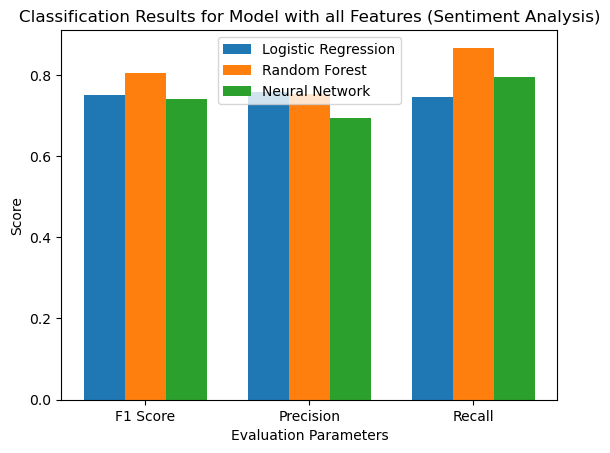

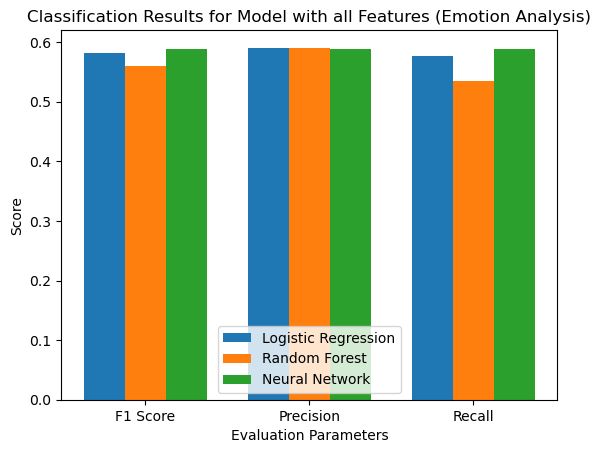

In [85]:
# Create function to visualize the evaluation metrics in a bar plot
def plot_classification_results(quantities, model_scores, model_names, title):
    # Set the width of the bars
    bar_width = 0.25
    # Set the positions of the bars on the x-axis
    index = np.arange(len(quantities))

    # Create the bar plot
    for i, scores in enumerate(model_scores):
        plt.bar(index + i * bar_width, scores, bar_width, label=model_names[i], linewidth=0.20)

    # Add labels and title
    plt.xlabel('Evaluation Parameters')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(index + bar_width * (len(model_scores) - 1) / 2, quantities)
    plt.legend()

    # Show the plot
    plt.show()

# Sentiment Analysis Results
quantities_sentiment = ['F1 Score', 'Precision', 'Recall']
logistic_regression_scores_sentiment = [np.mean(cv_f1_scores_log), np.mean(cv_precision_scores_log), np.mean(cv_recall_scores_log)]
random_forest_scores_sentiment = [np.mean(cv_f1_scores_rf), np.mean(cv_precision_scores_rf), np.mean(cv_recall_scores_rf)]
neural_network_scores_sentiment = [f1_score_nn, precision_nn, recall_nn]

model_scores_sentiment = [logistic_regression_scores_sentiment, random_forest_scores_sentiment, neural_network_scores_sentiment]
model_names_sentiment = ['Logistic Regression', 'Random Forest', 'Neural Network']

# Emotion Analysis Results
quantities_emotion = ['F1 Score', 'Precision', 'Recall']
logistic_regression_scores_emotion = [np.mean(cv_f1_scores_log_em), np.mean(cv_precision_scores_log_em), np.mean(cv_recall_scores_log_em)]
random_forest_scores_emotion = [np.mean(cv_f1_scores_rf_em), np.mean(cv_precision_scores_rf_em), np.mean(cv_recall_scores_rf_em)]
neural_network_scores_emotion = [f1_score_nn_em, precision_nn_em, recall_nn_em]

model_scores_emotion = [logistic_regression_scores_emotion, random_forest_scores_emotion, neural_network_scores_emotion]
model_names_emotion = ['Logistic Regression', 'Random Forest', 'Neural Network']

# Create the bar plot for Sentiment Analysis Results
plot_classification_results(quantities_sentiment, model_scores_sentiment, model_names_sentiment, 'Classification Results for Model with all Features (Sentiment Analysis)')

# Create the bar plot for Emotion Analysis Results
plot_classification_results(quantities_emotion, model_scores_emotion, model_names_emotion, 'Classification Results for Model with all Features (Emotion Analysis)')

# PART 6: 
## FEATURE SELECTION TECHNIQUES
###  A. Variance Threshold
#### A1.1) Logistic Regression and Random Forest (Sentiment Analysis)

In [86]:
# Apply variance threshold to select features
var_threshold = VarianceThreshold(threshold=0.2)
X_all_selected = var_threshold.fit_transform(X_all)

# Get the selected features
selected_features = np.array(X_all.columns)[var_threshold.get_support()]

# Split the data into training and testing sets
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all_selected, y_all, test_size=0.2, random_state=42)

# Rest of the code remains unchanged

# Initialize Classifiers
model_var_log = LogisticRegression(max_iter=10000)
model_var_rf = RandomForestClassifier()

# Fit the models to the training data
model_var_log.fit(X_all_train, y_all_train)
model_var_rf.fit(X_all_train, y_all_train)

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
cv_results_var = cross_validate(model_var_log, X_all_train, y_all_train, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf_var = cross_validate(model_var_rf, X_all_train, y_all_train, cv=k, scoring=scoring)

# Extract the evaluation metrics for logistic regression
cv_accuracy_scores_log_var = cv_results_var['test_accuracy']
cv_f1_scores_log_var = cv_results_var['test_f1']
cv_precision_scores_log_var = cv_results_var['test_precision']
cv_recall_scores_log_var = cv_results_var['test_recall']

# Extract the evaluation metrics for random forest
cv_accuracy_scores_rf_var = cv_results_rf_var['test_accuracy']
cv_f1_scores_rf_var = cv_results_rf_var['test_f1']
cv_precision_scores_rf_var = cv_results_rf_var['test_precision']
cv_recall_scores_rf_var = cv_results_rf_var['test_recall']

# Store the results in a new dataset
var_results_df = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_var), np.mean(cv_accuracy_scores_rf_var)],
    'F1 Score': [np.mean(cv_f1_scores_log_var), np.mean(cv_f1_scores_rf_var)],
    'Precision': [np.mean(cv_precision_scores_log_var), np.mean(cv_precision_scores_rf_var)],
    'Recall': [np.mean(cv_recall_scores_log_var), np.mean(cv_recall_scores_rf_var)]
})

# Print the selected features
print("Selected Features:")
print(selected_features)

# Display the results 
var_results_df

Selected Features:
['LexDens' 'TTR' 'CTTR' 'GTTR' 'MTLD' 'VerbVar' 'NounVar' 'AdjVar'
 'AdvVar' 'profanity_words' 'Conjunctions' 'Pronouns' 'Auxiliary Verbs'
 'Modal Verbs' 'Determiners' 'Number of Phrases' 'NP Ratio' 'AdvP Ratio'
 'AdjP Ratio' 'PrpP Ratio' 'VP Ratio' 'Complex Nominals'
 'Subordinate Clauses' 'Relative Clauses' 'Tree Depth' 'nsubj' 'dobj'
 'amod' 'Contrast Markers' 'Negative Affixes' 'Past Verbs'
 'Infinitive Verbs' 'has_passive_voice' 'negative_polarity'
 'positive_polarity' 'avg_synsets' 'mean_concreteness'
 'Named Entity Count']


,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.744053,0.748414,0.751645,0.746154
1,Random Forest,0.790038,0.808362,0.758633,0.866667


#### A1.2) Logistic Regression and Random Forest (Emotion Analysis)

In [87]:
# Apply variance threshold to select features
var_threshold_em = VarianceThreshold(threshold=0.01)
X_all_selected_em = var_threshold_em.fit_transform(X_all_em)

# Get the selected features
selected_features_em = np.array(X_all_em.columns)[var_threshold_em.get_support()]

# Split the data into training and testing sets
X_all_train_em, X_all_test_em, y_all_train_em, y_all_test_em = train_test_split(X_all_selected_em, y_all_em, test_size=0.2, random_state=42)

# Rest of the code remains unchanged

# Initialize Classifiers
model_var_log_em = LogisticRegression(max_iter=10000)
model_var_rf_em = RandomForestClassifier()

# Fit the models to the training data
model_var_log_em.fit(X_all_train_em, y_all_train_em)
model_var_rf_em.fit(X_all_train_em, y_all_train_em)

# Set up k-fold cross-validation for logistic regression
k_em = 10  # Number of folds
scoring_em = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
cv_results_var_em = cross_validate(model_var_log_em, X_all_train_em, y_all_train_em, cv=k_em, scoring=scoring_em)

# Set up k-fold cross-validation for random forest
cv_results_rf_var_em = cross_validate(model_var_rf_em, X_all_train_em, y_all_train_em, cv=k_em, scoring=scoring_em)

# Extract the evaluation metrics for logistic regression
cv_accuracy_scores_log_var_em = cv_results_var_em['test_accuracy']
cv_f1_scores_log_var_em = cv_results_var_em['test_f1']
cv_precision_scores_log_var_em = cv_results_var_em['test_precision']
cv_recall_scores_log_var_em = cv_results_var_em['test_recall']

# Extract the evaluation metrics for random forest
cv_accuracy_scores_rf_var_em = cv_results_rf_var_em['test_accuracy']
cv_f1_scores_rf_var_em = cv_results_rf_var_em['test_f1']
cv_precision_scores_rf_var_em = cv_results_rf_var_em['test_precision']
cv_recall_scores_rf_var_em = cv_results_rf_var_em['test_recall']

# Store the results in a new dataset
var_results_df_em = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_var_em), np.mean(cv_accuracy_scores_rf_var_em)],
    'F1 Score': [np.mean(cv_f1_scores_log_var_em), np.mean(cv_f1_scores_rf_var_em)],
    'Precision': [np.mean(cv_precision_scores_log_var_em), np.mean(cv_precision_scores_rf_var_em)],
    'Recall': [np.mean(cv_recall_scores_log_var_em), np.mean(cv_recall_scores_rf_var_em)]
})

# Print the selected features
print("Selected Features:")
print(selected_features_em)

# Display the results 
var_results_df_em

Selected Features:
['LexDens' 'TTR' 'CTTR' 'GTTR' 'MTLD' 'VerbVar' 'NounVar' 'AdjVar'
 'AdvVar' 'non_standard' 'profanity_words' 'Articles' 'Prepositions'
 'Conjunctions' 'Pronouns' 'Auxiliary Verbs' 'Modal Verbs' 'Determiners'
 'Number of Phrases' 'NP Ratio' 'AdvP Ratio' 'AdjP Ratio' 'PrpP Ratio'
 'VP Ratio' 'Complex Nominals' 'Subordinate Clauses' 'Relative Clauses'
 'Number of Characters' 'Number of Words' 'Tree Depth' 'paren_count'
 'Contrast Markers' 'Emphatic Markers' 'nsubj' 'dobj' 'amod'
 'Concessive Markers' 'Summary Markers' 'Negative Affixes' 'Present Verbs'
 'Past Verbs' 'Future Verbs' 'Infinitive Verbs' 'has_passive_voice'
 'negative_polarity' 'positive_polarity' 'avg_synsets' 'mean_concreteness'
 'Named Entity Count']


,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.591234,0.582235,0.590698,0.577542
1,Random Forest,0.580275,0.563855,0.581115,0.551785


#### A2.1) MLP Neural Network (Sentiment Analysis)

In [88]:
# Define the neural network architecture
model_var = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_all_selected.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model_var.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_var.fit(X_all_train, y_all_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model_var.evaluate(X_all_test, y_all_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/20
20/20 [==============================] - 2s 14ms/step - loss: 0.5854 - accuracy: 0.6798 - val_loss: 0.5830 - val_accuracy: 0.7124
Epoch 2/20
20/20 [==============================] - 0s 6ms/step - loss: 0.4617 - accuracy: 0.7898 - val_loss: 0.5725 - val_accuracy: 0.7451
Epoch 3/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4204 - accuracy: 0.8177 - val_loss: 0.5994 - val_accuracy: 0.7124
Epoch 4/20
20/20 [==============================] - 0s 5ms/step - loss: 0.3821 - accuracy: 0.8539 - val_loss: 0.5418 - val_accuracy: 0.7451
Epoch 5/20
20/20 [==============================] - 0s 6ms/step - loss: 0.3501 - accuracy: 0.8654 - val_loss: 0.5484 - val_accuracy: 0.7386
Epoch 6/20
20/20 [==============================] - 0s 5ms/step - loss: 0.3336 - accuracy: 0.8703 - val_loss: 0.5769 - val_accuracy: 0.7255
Epoch 7/20
20/20 [==============================] - 0s 5ms/step - loss: 0.3018 - accuracy: 0.8966 - val_loss: 0.5399 - val_accuracy: 0.7451
Epoch 8/20
20/20 [=

#### A2.2) MLP Neural Network (Emotion Analysis)

In [89]:
# Define the neural network architecture
model_var_em = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_all_selected_em.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model_var_em.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping_em = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_var_em.fit(X_all_train_em, y_all_train_em, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping_em])

# Evaluate the model on the test set
test_loss_em, test_accuracy_em = model_var_em.evaluate(X_all_test_em, y_all_test_em)
print(f'Test Loss: {test_loss_em}, Test Accuracy: {test_accuracy_em}')

Epoch 1/20
28/28 [==============================] - 2s 11ms/step - loss: 0.6898 - accuracy: 0.5753 - val_loss: 0.6550 - val_accuracy: 0.6273
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6195 - accuracy: 0.6541 - val_loss: 0.6838 - val_accuracy: 0.5955
Epoch 3/20
28/28 [==============================] - 0s 5ms/step - loss: 0.5825 - accuracy: 0.7066 - val_loss: 0.6854 - val_accuracy: 0.6045
Epoch 4/20
9/9 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6168
Test Loss: 0.654340386390686, Test Accuracy: 0.6167883276939392


###  B. Correlation
#### B1.1) Logistic Regression and Random Forest (Sentiment Analysis)

In [90]:
# Select specific columns from the 'data' df
X = data[['LexDens', 'TTR', 'CTTR', 'GTTR', 'MTLD', 'VerbVar', 'NounVar',
       'AdjVar', 'AdvVar', 'non_standard', 'profanity_words',
       'Articles', 'Prepositions', 'Conjunctions', 'Pronouns',
       'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases',
       'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio',
       'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses',
       'Number of Characters', 'Number of Words', 'Tree Depth', 'paren_count',
       'nsubj', 'dobj', 'amod', 'Contrast Markers', 'Emphatic Markers',
       'Concessive Markers', 'Summary Markers', 'Negative Affixes',
       'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs',
       'has_passive_voice', 'negative_polarity', 'positive_polarity',
       'avg_synsets', 'mean_concreteness', 'Named Entity Count']]

# Calculate the correlation matrix for the selected columns
correlations = X.corr()

In [91]:
# Get correlations of each feature in the dataset
correlations = X.corr()

# Set the standard threshold for correlation
threshold = 0.6

# Create a set to store the correlated feature pairs
correlated_pairs = set()

# Iterate over the correlation matrix and find the correlated pairs
for i in range(len(correlations.columns)):
    for j in range(i+1, len(correlations.columns)):
        if abs(correlations.iloc[i, j]) > threshold:
            correlated_pairs.add((correlations.columns[i], correlations.columns[j]))

# Print the correlated feature pairs
for pair in correlated_pairs:
    print(f"{pair[0]} and {pair[1]} are correlated.")

Prepositions and Number of Words are correlated.
Number of Phrases and Tree Depth are correlated.
Complex Nominals and Number of Words are correlated.
GTTR and Number of Characters are correlated.
Prepositions and Number of Characters are correlated.
GTTR and non_standard are correlated.
non_standard and Complex Nominals are correlated.
nsubj and dobj are correlated.
non_standard and Number of Words are correlated.
Complex Nominals and Number of Characters are correlated.
TTR and Number of Words are correlated.
Number of Characters and Number of Words are correlated.
Articles and Number of Words are correlated.
AdvVar and AdvP Ratio are correlated.
GTTR and Prepositions are correlated.
GTTR and Articles are correlated.
non_standard and Number of Characters are correlated.
GTTR and Complex Nominals are correlated.
TTR and GTTR are correlated.
Articles and Number of Characters are correlated.
Prepositions and Complex Nominals are correlated.
GTTR and Number of Words are correlated.


In [92]:
# Create a list to store the non-correlated feature names
non_correlated_features = list(X.columns)

# Iterate over the correlated feature pairs
for feature_1, feature_2 in correlated_pairs:
    # Check if the features are still in the non-correlated features list
    if feature_1 in non_correlated_features and feature_2 in non_correlated_features:
        # Remove one of the correlated features from the list
        non_correlated_features.remove(feature_2)

# Create a new dataset with non-correlated features
new_data = X[non_correlated_features]

In [93]:
# Split the data into features (X) and target (y)
X_cor = data[['LexDens', 'TTR', 'CTTR', 'MTLD', 'VerbVar', 'NounVar', 'AdjVar', 'AdvVar',
              'profanity_words', 'Conjunctions','Pronouns', 'Articles', 'Auxiliary Verbs', 'Modal Verbs', 'Number of Phrases',
              'NP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio', 'Subordinate Clauses', 'Complex Nominals',
              'Relative Clauses', 'paren_count','nsubj', 'amod', 'Contrast Markers', 'Emphatic Markers',
              'Concessive Markers', 'Summary Markers','Present Verbs','Past Verbs', 'Future Verbs', 'has_passive_voice',
              'negative_polarity', 'positive_polarity', 'avg_synsets', 'mean_concreteness',
              'Named Entity Count']]

y_cor = data['Misprediction']

# Split the data into training and testing sets
X_cor_train, X_cor_test, y_cor_train, y_cor_test = train_test_split(X_cor, y_cor, test_size=0.2, random_state=42)

# Initialize Classifiers
model_cor_log = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_cor_rf = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_cor_log.fit(X_cor_train, y_cor_train) # Logistic regression
model_cor_rf.fit(X_cor_train, y_cor_train) # Random Forest

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
cv_results_log_cor = cross_validate(model_cor_log, X_cor_train, y_cor_train, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf_cor = cross_validate(model_cor_rf, X_cor_train, y_cor_train, cv=k, scoring=scoring)

# Extract the evaluation metrics for logistic regression
cv_accuracy_scores_log_cor = cv_results_log_cor['test_accuracy']
cv_f1_scores_log_cor = cv_results_log_cor['test_f1']

# Extract the evaluation metrics for random forest
cv_accuracy_scores_rf_cor = cv_results_rf_cor['test_accuracy']
cv_f1_scores_rf_cor = cv_results_rf_cor['test_f1']

# Calculate evaluation metrics for logistic regression on the test set
precision_log_cor = precision_score(y_cor_test, model_cor_log.predict(X_cor_test))
recall_log_cor = recall_score(y_cor_test, model_cor_log.predict(X_cor_test))

# Calculate evaluation metrics for random forest on the test set
precision_rf_cor = precision_score(y_cor_test, model_cor_rf.predict(X_cor_test))
recall_rf_cor = recall_score(y_cor_test, model_cor_rf.predict(X_cor_test))

# Store the results in a new df
results_cor = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_cor), np.mean(cv_accuracy_scores_rf_cor)],
    'F1 Score': [np.mean(cv_f1_scores_log_cor), np.mean(cv_f1_scores_rf_cor)],
    'Precision': [precision_log_cor, precision_rf_cor],
    'Recall': [recall_log_cor, recall_rf_cor]
})

results_cor

,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.753247,0.758799,0.673469,0.750000
1,Random Forest,0.776897,0.798221,0.695238,0.829545


#### B1.2) Logistic Regression and Random Forest (Emotion Analysis)

In [94]:
# Select specific columns from the 'data_em' df
X_em = data_em[['LexDens', 'TTR', 'CTTR', 'GTTR', 'MTLD', 'VerbVar', 'NounVar',
       'AdjVar', 'AdvVar', 'non_standard', 'profanity_words',
       'Articles', 'Prepositions', 'Conjunctions', 'Pronouns',
       'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases',
       'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio',
       'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses',  'nsubj', 'dobj', 'amod',
       'Number of Characters', 'Number of Words', 'Tree Depth', 'paren_count',
        'Contrast Markers', 'Emphatic Markers', 'nsubj', 'dobj', 'amod',
       'Concessive Markers', 'Summary Markers', 'Negative Affixes',
       'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs',
       'has_passive_voice', 'negative_polarity', 'positive_polarity',
       'avg_synsets', 'mean_concreteness', 'Named Entity Count']]


# Calculate the correlation matrix for the selected columns
correlations_em = X_em.corr()

In [95]:
# Get correlations of each feature in the dataset
correlations_em = X_em.corr()

# Set the standard threshold for correlation
threshold = 0.6

# Create a set to store the correlated feature pairs
correlated_pairs_em = set()

# Iterate over the correlation matrix and find the correlated pairs
for i in range(len(correlations_em.columns)):
    for j in range(i+1, len(correlations_em.columns)):
        if abs(correlations_em.iloc[i, j]) > threshold:
            correlated_pairs_em.add((correlations_em.columns[i], correlations_em.columns[j]))

# Print the correlated feature pairs
for pair in correlated_pairs_em:
    print(f"{pair[0]} and {pair[1]} are correlated.")

Pronouns and Number of Words are correlated.
Number of Words and nsubj are correlated.
Number of Phrases and Number of Characters are correlated.
Prepositions and Number of Words are correlated.
Conjunctions and Number of Words are correlated.
nsubj and Number of Characters are correlated.
Number of Phrases and Tree Depth are correlated.
non_standard and Prepositions are correlated.
Complex Nominals and Number of Words are correlated.
nsubj and Present Verbs are correlated.
non_standard and nsubj are correlated.
dobj and dobj are correlated.
Number of Characters and Tree Depth are correlated.
Prepositions and Number of Characters are correlated.
Conjunctions and Number of Characters are correlated.
non_standard and Complex Nominals are correlated.
Prepositions and Number of Phrases are correlated.
Prepositions and Tree Depth are correlated.
Number of Phrases and nsubj are correlated.
non_standard and Number of Words are correlated.
Complex Nominals and Number of Characters are correlat

In [96]:
# Create a list to store the non-correlated feature names
non_correlated_features_em = list(X_em.columns)

# Iterate over the correlated feature pairs
for feature_1, feature_2 in correlated_pairs_em:
    # Check if the features are still in the non-correlated features list
    if feature_1 in non_correlated_features_em and feature_2 in non_correlated_features_em:
        # Remove one of the correlated features from the list
        non_correlated_features_em.remove(feature_2)

# Create a new dataset with non-correlated features
new_data_em = X_em[non_correlated_features_em]

In [97]:
# Print the non-correlated feature names
print("Non-correlated features:")
for feature in non_correlated_features_em:
    print(feature)

Non-correlated features:
LexDens
TTR
CTTR
MTLD
VerbVar
NounVar
AdjVar
AdvVar
non_standard
profanity_words
Articles
Pronouns
Auxiliary Verbs
Modal Verbs
Determiners
NP Ratio
AdjP Ratio
PrpP Ratio
VP Ratio
Subordinate Clauses
Relative Clauses
paren_count
Contrast Markers
Emphatic Markers
dobj
amod
Concessive Markers
Summary Markers
Negative Affixes
Past Verbs
Future Verbs
Infinitive Verbs
has_passive_voice
negative_polarity
positive_polarity
avg_synsets
mean_concreteness
Named Entity Count


In [98]:
# Split the data into features (X) and target (y)
X_cor_em = data_em[['LexDens', 'TTR', 'MTLD', 'VerbVar', 'NounVar', 'AdjVar', 'profanity_words', 'Number of Phrases', 'Auxiliary Verbs',
              'NP Ratio', 'AdjP Ratio', 'AdvP Ratio', 'VP Ratio', 'Subordinate Clauses', 'Relative Clauses', 'Contrast Markers',
              'Emphatic Markers', 'Concessive Markers','Summary Markers', 'positive_polarity', 'negative_polarity','has_passive_voice', 'avg_synsets', 'mean_concreteness']]
y_cor_em = data_em['Misprediction']

# Split the data into training and testing sets
X_cor_train_em, X_cor_test_em, y_cor_train_em, y_cor_test_em = train_test_split(X_cor_em, y_cor_em, test_size=0.2, random_state=42)

# Initialize Classifiers
model_cor_log_em = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_cor_rf_em = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_cor_log_em.fit(X_cor_train_em, y_cor_train_em) # Logistic regression
model_cor_rf_em.fit(X_cor_train_em, y_cor_train_em) # Random Forest

# Set up k-fold cross-validation for logistic regression
k_em = 10  # Number of folds
scoring_em = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
cv_results_log_cor_em = cross_validate(model_cor_log_em, X_cor_train_em, y_cor_train_em, cv=k_em, scoring=scoring_em)

# Set up k-fold cross-validation for random forest
cv_results_rf_cor_em = cross_validate(model_cor_rf_em, X_cor_train_em, y_cor_train_em, cv=k_em, scoring=scoring_em)

# Extract the evaluation metrics for logistic regression
cv_accuracy_scores_log_cor_em = cv_results_log_cor_em['test_accuracy']
cv_f1_scores_log_cor_em = cv_results_log_cor_em['test_f1']

# Extract the evaluation metrics for random forest
cv_accuracy_scores_rf_cor_em = cv_results_rf_cor_em['test_accuracy']
cv_f1_scores_rf_cor_em = cv_results_rf_cor_em['test_f1']

# Calculate the evaluation metrics for logistic regression on the test set
precision_log_cor_em = precision_score(y_cor_test_em, model_cor_log_em.predict(X_cor_test_em))
recall_log_cor_em = recall_score(y_cor_test_em, model_cor_log_em.predict(X_cor_test_em))

# Calculate the evaluation metrics for random forest on the test set
precision_rf_cor_em = precision_score(y_cor_test_em, model_cor_rf_em.predict(X_cor_test_em))
recall_rf_cor_em = recall_score(y_cor_test_em, model_cor_rf_em.predict(X_cor_test_em))

# Store the results in a new dataset
results_cor_em = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_cor_em), np.mean(cv_accuracy_scores_rf_cor_em)],
    'F1 Score': [np.mean(cv_f1_scores_log_cor_em), np.mean(cv_f1_scores_rf_cor_em)],
    'Precision': [precision_log_cor_em, precision_rf_cor_em],
    'Recall': [recall_log_cor_em, recall_rf_cor_em]
})

results_cor_em

,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.566689,0.544352,0.595238,0.531915
1,Random Forest,0.558449,0.534594,0.600000,0.531915


#### B2.1) MLP Neural Network (Sentiment Analysis)

In [99]:
# Define the neural network architecture
model_cor = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(len(X_cor.columns),)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model_cor.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_cor.fit(X_cor_train, y_cor_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model_cor.evaluate(X_cor_test, y_cor_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/20
20/20 [==============================] - 1s 14ms/step - loss: 0.6033 - accuracy: 0.6667 - val_loss: 0.5859 - val_accuracy: 0.6928
Epoch 2/20
20/20 [==============================] - 0s 6ms/step - loss: 0.4873 - accuracy: 0.7685 - val_loss: 0.5834 - val_accuracy: 0.7255
Epoch 3/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4476 - accuracy: 0.8046 - val_loss: 0.6251 - val_accuracy: 0.6863
Epoch 4/20
20/20 [==============================] - 0s 11ms/step - loss: 0.4108 - accuracy: 0.8259 - val_loss: 0.5642 - val_accuracy: 0.7386
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 0.3792 - accuracy: 0.8522 - val_loss: 0.5921 - val_accuracy: 0.6797
Epoch 6/20
20/20 [==============================] - 0s 8ms/step - loss: 0.3582 - accuracy: 0.8522 - val_loss: 0.6205 - val_accuracy: 0.6863
Epoch 7/20
6/6 [==============================] - 0s 3ms/step - loss: 0.5576 - accuracy: 0.7382
Test Loss: 0.5575805902481079, Test Accuracy: 0.73821991682052

#### B2.2) MLP Neural Network (Emotion Analysis)

In [100]:
# Define the neural network architecture
model_cor_em = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(len(X_cor_em.columns),)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
model_cor_em.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping_em = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_cor_em.fit(X_cor_train_em, y_cor_train_em, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping_em])

# Evaluate the model on the test set
test_loss_em, test_accuracy_em = model_cor_em.evaluate(X_cor_test_em, y_cor_test_em)
print(f'Test Loss: {test_loss_em}, Test Accuracy: {test_accuracy_em}')

Epoch 1/20
28/28 [==============================] - 2s 11ms/step - loss: 0.6951 - accuracy: 0.5308 - val_loss: 0.6670 - val_accuracy: 0.5818
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6433 - accuracy: 0.6290 - val_loss: 0.6731 - val_accuracy: 0.5864
Epoch 3/20
28/28 [==============================] - 0s 5ms/step - loss: 0.6157 - accuracy: 0.6758 - val_loss: 0.6908 - val_accuracy: 0.5682
Epoch 4/20
9/9 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.5803
Test Loss: 0.6800695061683655, Test Accuracy: 0.5802919864654541


###  C. Relief
#### C1.1) Logistic Regression and Random Forest (Sentiment Analysis)

In [101]:
# Perform feature selection using Relief
selector = SelectKBest(score_func=f_regression, k=10)  # Adjust the k value as desired
X_selected = selector.fit_transform(X_all, y_all)

# Get the selected feature names
selected_feature_names = X_all.columns[selector.get_support()]

# Split the data into training and testing sets
X_selected_train, X_selected_test, y_all_train, y_all_test = train_test_split(X_selected, y_all, test_size=0.2, random_state=42)

# Initialize Classifier
model_complex_log_relief = LogisticRegression(max_iter=10000)  # Create a logistic regression classifier

# Fit the model to the training data with the selected features
model_complex_log_relief.fit(X_selected_train, y_all_train)  # Logistic regression

# Set up k-fold cross-validation for logistic regression with the selected features
cv_results_log_relief = cross_validate(model_complex_log_relief, X_selected_train, y_all_train, cv=k, scoring=scoring)

# Define the scoring metrics you want to evaluate
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

# Set k value for k-fold cross-validation
k = 5  # Adjust k as desired

# Perform k-fold cross-validation for logistic regression with the selected features
cv_results_log_relief = cross_validate(model_complex_log_relief, X_selected_train, y_all_train, cv=k, scoring=scoring)

# Print the evaluation metrics
print("Accuracy:", np.mean(cv_results_log_relief['test_accuracy']))
print("Precision:", np.mean(cv_results_log_relief['test_precision']))
print("Recall:", np.mean(cv_results_log_relief['test_recall']))
print("F1 Score:", np.mean(cv_results_log_relief['test_f1_score']))

Accuracy: 0.7598727210182318
Precision: 0.7639076217899747
Recall: 0.7692307692307693
F1 Score: 0.7662186713247818


# PART 7: 
## DIAGNOSTIC ASSESSMENT OF FEATURES
### A. Regression Analysis 
#### 7A1. Sentiment Analysis Task

In [102]:
# Select features from X_cor dataset
X_selected = data[['LexDens','TTR' , 'CTTR','MTLD' ,'VerbVar', 'NounVar' ,'AdjVar',
 'AdvVar' ,'profanity_words' ,'Articles','Conjunctions', 'Pronouns', 'Auxiliary Verbs',
 'Modal Verbs' ,'Determiners' ,'Number of Phrases' ,'NP Ratio' ,'AdvP Ratio',
 'AdjP Ratio' ,'PrpP Ratio' ,'VP Ratio', 'Complex Nominals',
 'Subordinate Clauses', 'Relative Clauses', 'nsubj',
 'amod' ,'Contrast Markers' ,'Negative Affixes' ,'Past Verbs',
 'Infinitive Verbs', 'has_passive_voice' ,'negative_polarity',
 'positive_polarity', 'avg_synsets' ,'mean_concreteness',
 'Named Entity Count']]


# Add constant term to the feature matrix
X_selected = sm.add_constant(X_selected)

# Fit logistic regression model
logit_model = sm.Logit(y_cor, X_selected)
result = logit_model.fit()

# Print the summary of the logistic regression model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.491826
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Misprediction   No. Observations:                  953
Model:                          Logit   Df Residuals:                      916
Method:                           MLE   Df Model:                           36
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.2904
Time:                        21:38:23   Log-Likelihood:                -468.71
converged:                       True   LL-Null:                       -660.56
Covariance Type:            nonrobust   LLR p-value:                 9.510e-60
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1532      0.111      1.377      0.169      -0.065       0.371
Le

In [103]:
# Get the absolute values of the coefficients
coefs_abs = np.abs(result.params)

# Create a new df storing the coefficients and their absolute values
coefs_df = pd.DataFrame({'Coefficient': result.params, 'Absolute Value': coefs_abs}, index=X_selected.columns)

# Sort the df by the absolute values in descending order
coefs_df_sorted = coefs_df.sort_values('Absolute Value', ascending=False)

# Select the specific features
selected_features = ['CTTR', 'Relative Clauses', 'Contrast Markers', 'AdvP Ratio','positive_polarity', 'nsubj', 'amod']

# Filter the df to include only the selected features
selected_coefs = coefs_df_sorted.loc[selected_features]

selected_coefs

,Coefficient,Absolute Value
CTTR,0.306820,0.306820
Relative Clauses,0.340361,0.340361
Contrast Markers,0.341256,0.341256
AdvP Ratio,-0.264269,0.264269
positive_polarity,-0.910690,0.910690
nsubj,1.052409,1.052409
amod,0.509184,0.509184


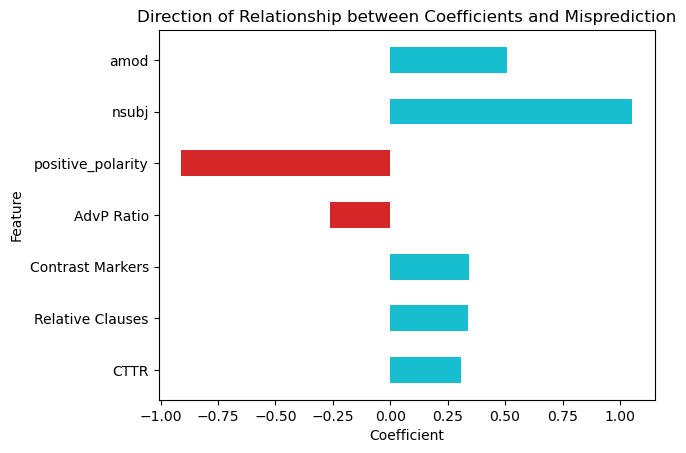

In [104]:
# Filter the df to include only the selected features
coefs_df_filtered = coefs_df_sorted.loc[selected_features]

# Set the width of the bars
bar_width = 0.5

# Set the positions of the bars on the y-axis
index = np.arange(len(coefs_df_filtered))

# Create the bar plot
plt.barh(index, coefs_df_filtered['Coefficient'], bar_width, color=['tab:red' if c < 0 else 'tab:cyan' for c in coefs_df_filtered['Coefficient']])

# Add labels and title
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Direction of Relationship between Coefficients and Misprediction')

# Add y-axis labels
plt.yticks(index, coefs_df_filtered.index)

# Show the plot
plt.show()

#### 7A2. Emotion Analysis Task

In [105]:
# Select the desired features from X_cor
X_selected_em = data_em[['LexDens', 'TTR', 'CTTR', 'VerbVar', 'NounVar', 'AdjVar', 'AdvVar', 'profanity_words', 'Conjunctions', 'Pronouns', 'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases', 'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio', 'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses', 'Contrast Markers', 'Emphatic Markers', 'nsubj', 'amod', 'Concessive Markers', 'Summary Markers', 'Negative Affixes', 'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs', 'has_passive_voice', 'negative_polarity', 'positive_polarity', 'avg_synsets', 'mean_concreteness', 'Named Entity Count']]


# Add constant term to the feature matrix
X_selected_em = sm.add_constant(X_selected_em)

# Fit logistic regression model
logit_model_em = sm.Logit(y_cor_em, X_selected_em)
result_em = logit_model_em.fit()

# Print the summary of the logistic regression model
print(result_em.summary())

Optimization terminated successfully.
         Current function value: 0.650042
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          Misprediction   No. Observations:                 1370
Model:                          Logit   Df Residuals:                     1330
Method:                           MLE   Df Model:                           39
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                 0.06218
Time:                        21:38:24   Log-Likelihood:                -890.56
converged:                       True   LL-Null:                       -949.61
Covariance Type:            nonrobust   LLR p-value:                 6.896e-10
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2283      0.210      1.089      0.276      -0.182       0.639
Le

In [106]:
# Get the absolute values of the coefficients
coefs_abs_em = np.abs(result_em.params)

# Create a df to store the coefficients and their absolute values
coefs_df_em = pd.DataFrame({'Coefficient': result_em.params, 'Absolute Value': coefs_abs_em}, index=X_selected_em.columns)

# Sort the df by the absolute values in descending order
coefs_df_sorted_em = coefs_df_em.sort_values('Absolute Value', ascending=False)

# Select the specific features
selected_features_em = ['VerbVar', 'Number of Phrases', 'AdvP Ratio', 'nsubj', 'amod', 'avg_synsets']

# Filter the DataFrame to include only the selected features
selected_coefs_em = coefs_df_sorted_em.loc[selected_features_em]

selected_coefs_em

,Coefficient,Absolute Value
VerbVar,0.150474,0.150474
Number of Phrases,-0.296307,0.296307
AdvP Ratio,0.465858,0.465858
nsubj,0.473740,0.473740
amod,0.273937,0.273937
avg_synsets,0.212857,0.212857


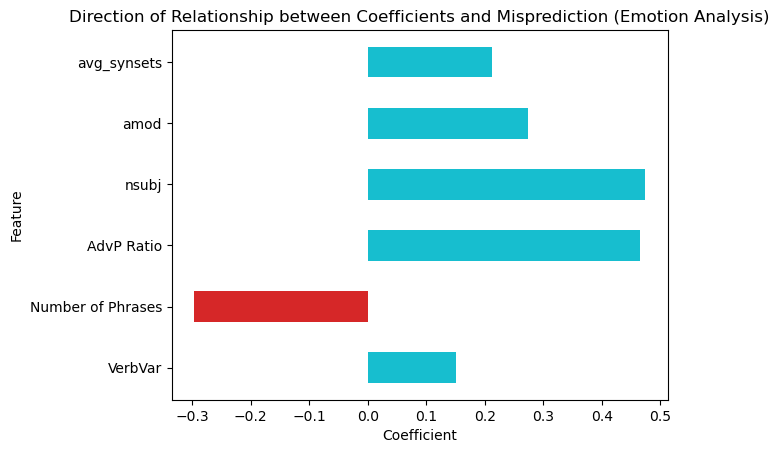

In [107]:
# Filter the df to include only the selected features
coefs_df_filtered_em = coefs_df_sorted_em.loc[selected_features_em]

# Set the width of the bars
bar_width = 0.5

# Set the positions of the bars on the y-axis
index = np.arange(len(coefs_df_filtered_em))

# Create the bar plot
plt.barh(index, coefs_df_filtered_em['Coefficient'], bar_width, color=['tab:red' if c < 0 else 'tab:cyan' for c in coefs_df_filtered_em['Coefficient']])

# Add labels and title
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Direction of Relationship between Coefficients and Misprediction (Emotion Analysis)')

# Add y-axis labels
plt.yticks(index, coefs_df_filtered_em.index)

# Show the plot
plt.show()

### B. SHAP Values
#### 7B1. Sentiment Analysis Task

In [108]:
# Split the data into features (X) and target (y)
X_final = data[['LexDens','TTR' , 'CTTR','MTLD' ,'VerbVar', 'NounVar' ,'AdjVar',
 'AdvVar' ,'profanity_words' ,'Articles','Conjunctions', 'Pronouns', 'Auxiliary Verbs',
 'Modal Verbs' ,'Determiners' ,'Number of Phrases' ,'NP Ratio' ,'AdvP Ratio',
 'AdjP Ratio' ,'PrpP Ratio' ,'VP Ratio', 'Complex Nominals',
 'Subordinate Clauses', 'Relative Clauses', 'nsubj',
 'amod' ,'Contrast Markers' ,'Negative Affixes' ,'Past Verbs',
 'Infinitive Verbs', 'has_passive_voice' ,'negative_polarity',
 'positive_polarity', 'avg_synsets' ,'mean_concreteness',
 'Named Entity Count']]
y_final = data['Misprediction']

# Split the data into training and testing sets
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Initialize Classifiers
model_final_log = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_final_rf = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_final_log.fit(X_final_train, y_final_train) # Logistic regression
model_final_rf.fit(X_final_train, y_final_train) # Random Forest

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
cv_results_log_final = cross_validate(model_final_log, X_final_train, y_final_train, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf_final = cross_validate(model_final_rf, X_final_train, y_final_train, cv=k, scoring=scoring)

# Extract the evaluation metrics from the cross-validation results for logistic regression
cv_accuracy_scores_log_final = cv_results_log_final['test_accuracy']
cv_f1_scores_log_final = cv_results_log_final['test_f1']
cv_precision_scores_log_final = cv_results_log_final['test_precision']
cv_recall_scores_log_final = cv_results_log_final['test_recall']

# Extract the the evaluation metrics from the cross-validation results for random forest
cv_accuracy_scores_rf_final = cv_results_rf_final['test_accuracy']
cv_f1_scores_rf_final = cv_results_rf_final['test_f1']
cv_precision_scores_rf_final = cv_results_rf_final['test_precision']
cv_recall_scores_rf_final = cv_results_rf_final['test_recall']

# Store the results in a new df
final_results_df = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_final), np.mean(cv_accuracy_scores_rf_final)],
    'F1 Score': [np.mean(cv_f1_scores_log_final), np.mean(cv_f1_scores_rf_final)],
    'Precision': [np.mean(cv_precision_scores_log_final), np.mean(cv_precision_scores_rf_final)],
    'Recall': [np.mean(cv_recall_scores_log_final), np.mean(cv_recall_scores_rf_final)]
})

final_results_df

,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.753264,0.758445,0.761307,0.756410
1,Random Forest,0.784774,0.804030,0.751497,0.866667


In [109]:
# Fit the explainer
explainer = shap.Explainer(model_final_log.predict, X_final_test)

# Calculate the SHAP values 
shap_values = explainer(X_final_test)

Permutation explainer: 192it [00:10,  2.11it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


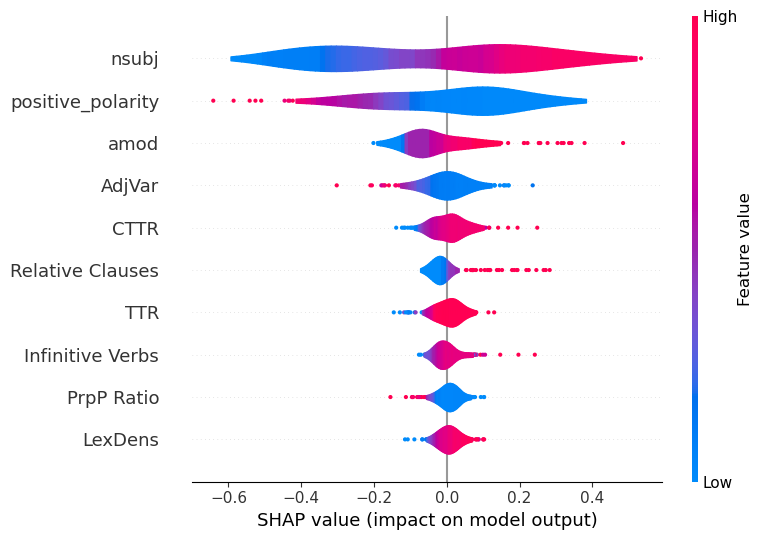

In [110]:
# Create a violin plot summarizing the SHAP values
shap.summary_plot(shap_values, plot_type='violin', max_display=10)

#### 7B2. Emotion Analysis Task

In [111]:
# Split the data into features (X) and target (y)
X_final_em = data_em[['LexDens', 'TTR', 'CTTR', 'VerbVar', 'NounVar', 'AdjVar', 'AdvVar', 'profanity_words', 'Conjunctions', 'Pronouns', 'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases', 'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio', 'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses', 'Contrast Markers', 'Emphatic Markers', 'nsubj', 'amod', 'Concessive Markers', 'Summary Markers', 'Negative Affixes', 'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs', 'has_passive_voice', 'negative_polarity', 'positive_polarity', 'avg_synsets', 'mean_concreteness', 'Named Entity Count']]
y_final_em = data_em['Misprediction']

# Split the data into training and testing sets
X_final_train_em, X_final_test_em, y_final_train_em, y_final_test_em = train_test_split(X_final_em, y_final_em, test_size=0.2, random_state=42)

# Initialize Classifiers
model_final_log_em = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_final_rf_em = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_final_log_em.fit(X_final_train_em, y_final_train_em) # Logistic regression
model_final_rf_em.fit(X_final_train_em, y_final_train_em) # Random Forest

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score),
           'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)}
cv_results_log_final_em = cross_validate(model_final_log_em, X_final_train_em, y_final_train_em, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf_final_em = cross_validate(model_final_rf_em, X_final_train_em, y_final_train_em, cv=k, scoring=scoring)

# Extract the evaluation metrics results for logistic regression
cv_accuracy_scores_log_final_em = cv_results_log_final_em['test_accuracy']
cv_f1_scores_log_final_em = cv_results_log_final_em['test_f1']
cv_precision_scores_log_final_em = cv_results_log_final_em['test_precision']
cv_recall_scores_log_final_em = cv_results_log_final_em['test_recall']

# Extract the evaluation metrics from the cross-validation results for random forest
cv_accuracy_scores_rf_final_em = cv_results_rf_final_em['test_accuracy']
cv_f1_scores_rf_final_em = cv_results_rf_final_em['test_f1']
cv_precision_scores_rf_final_em = cv_results_rf_final_em['test_precision']
cv_recall_scores_rf_final_em = cv_results_rf_final_em['test_recall']

# Store the results in a new df
final_results_df_em = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_final_em), np.mean(cv_accuracy_scores_rf_final_em)],
    'F1 Score': [np.mean(cv_f1_scores_log_final_em), np.mean(cv_f1_scores_rf_final_em)],
    'Precision': [np.mean(cv_precision_scores_log_final_em), np.mean(cv_precision_scores_rf_final_em)],
    'Recall': [np.mean(cv_recall_scores_log_final_em), np.mean(cv_recall_scores_rf_final_em)]
})

final_results_df_em

,Classifier,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.576706,0.566660,0.575524,0.561010
1,Random Forest,0.586739,0.574943,0.585919,0.568451


Permutation explainer: 275it [00:11,  3.76it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


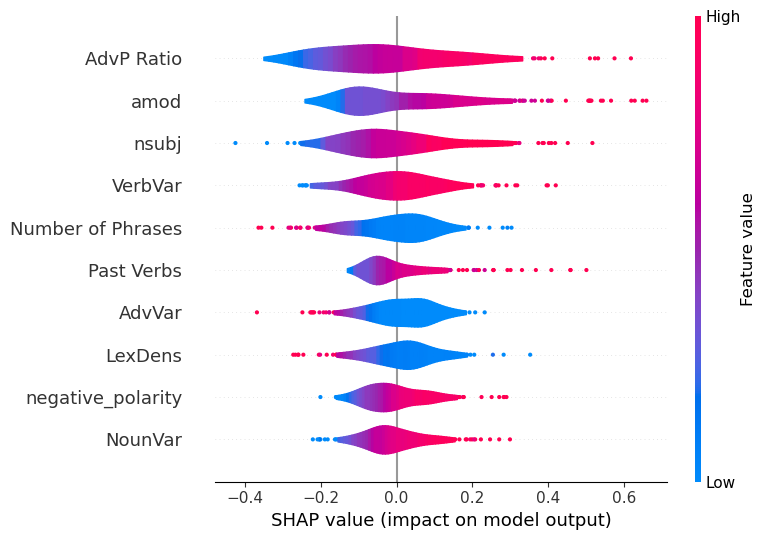

In [112]:
# Fit the explainer
explainer = shap.Explainer(model_final_log_em.predict, X_final_test_em)
# Calculate the SHAP values 
shap_values = explainer(X_final_test_em)

# Create a violin plot summarizing the SHAP values
shap.summary_plot(shap_values, plot_type='violin', max_display=10)

### C. Feature Ablation
#### C1. Sentiment Analysis Task

In [113]:
# Split the data into features (X) and target (y)
X_cor = data[['LexDens', 'TTR', 'CTTR', 'VerbVar', 'NounVar', 'AdjVar', 'AdvVar', 'profanity_words', 'Conjunctions', 'Pronouns', 'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases', 'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio', 'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses', 'Contrast Markers', 'Emphatic Markers', 'nsubj', 'amod', 'Concessive Markers', 'Summary Markers', 'Negative Affixes', 'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs', 'has_passive_voice', 'negative_polarity', 'positive_polarity', 'avg_synsets', 'mean_concreteness', 'Named Entity Count']]

y_cor = data['Misprediction']

# Split the data into training and testing sets
X_cor_train, X_cor_test, y_cor_train, y_cor_test = train_test_split(X_cor, y_cor, test_size=0.2, random_state=42)

# Initialize Classifiers
model_cor_log = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_cor_rf = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_cor_log.fit(X_cor_train, y_cor_train) # Logistic regression
model_cor_rf.fit(X_cor_train, y_cor_train) # Random Forest

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
cv_results_log_cor = cross_validate(model_cor_log, X_cor_train, y_cor_train, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf_cor = cross_validate(model_cor_rf, X_cor_train, y_cor_train, cv=k, scoring=scoring)

# Extract the evaluation metrics from the cross-validation results for logistic regression
cv_accuracy_scores_log_cor = cv_results_log_cor['test_accuracy']
cv_f1_scores_log_cor = cv_results_log_cor['test_f1']

# Extract the evaluation metrics from the cross-validation results for random forest
cv_accuracy_scores_rf_cor = cv_results_rf_cor['test_accuracy']
cv_f1_scores_rf_cor = cv_results_rf_cor['test_f1']

# Calculate evaluation metrics for logistic regression on the test set
precision_log_cor = precision_score(y_cor_test, model_cor_log.predict(X_cor_test))
recall_log_cor = recall_score(y_cor_test, model_cor_log.predict(X_cor_test))

# Calculate evaluation metric scores for random forest on the test set
precision_rf_cor = precision_score(y_cor_test, model_cor_rf.predict(X_cor_test))
recall_rf_cor = recall_score(y_cor_test, model_cor_rf.predict(X_cor_test))

# Store the results in a new df
results_cor = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_cor), np.mean(cv_accuracy_scores_rf_cor)],
    'F1 Score': [np.mean(cv_f1_scores_log_cor), np.mean(cv_f1_scores_rf_cor)],
    'Precision': [precision_log_cor, precision_rf_cor],
    'Recall': [recall_log_cor, recall_rf_cor]
})

# List of feature names
feature_names = X_cor.columns.tolist()

# Dictionary to store the results
feature_results = {}

# Iterate over each feature to ablate
for feature in feature_names:
    # Iterate over each classifier
    for classifier, model in zip(['Logistic Regression', 'Random Forest'], [model_cor_log, model_cor_rf]):
        # Create a new model for each ablated feature using clone()
        model = clone(model)
        
        # Check if the feature exists in the input data
        if feature not in X_cor_train.columns:
            continue

        # Remove the feature from the input data
        X_train_ablated = X_cor_train.drop(feature, axis=1)
        X_test_ablated = X_cor_test.drop(feature, axis=1)

        # Train the model
        model.fit(X_train_ablated, y_cor_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test_ablated)
        classification_rep = classification_report(y_cor_test, y_pred, output_dict=True)
        f1_measure = classification_rep['weighted avg']['f1-score']
        delta_value = f1_measure - results_cor.loc[results_cor['Classifier'] == classifier, 'F1 Score'].values[0]

        # Store the results
        if feature not in feature_results:
            feature_results[feature] = {}
        feature_results[feature][classifier] = {'F1 Measure': f1_measure, 'Delta Value': delta_value}


# Create empty lists to store the results
feature_list = []
classifier_list = []
f1_measure_list = []
delta_value_list = []

# Iterate over the results dictionary
for feature, classifier_results in feature_results.items():
    for classifier, result in classifier_results.items():
        # Append the feature, classifier, F1 measure, and delta value to the respective lists
        feature_list.append(feature)
        classifier_list.append(classifier)
        f1_measure_list.append(result['F1 Measure'])
        delta_value_list.append(result['Delta Value'])

# Create a dictionary to store the data
data_feat_abl = {
    'Feature': feature_list,
    'Classifier': classifier_list,
    'F1 Measure': f1_measure_list,
    'Delta Value': delta_value_list
}

df_ablation = pd.DataFrame(data_feat_abl)
df_ablation

,Feature,Classifier,F1 Measure,Delta Value
0,LexDens,Logistic Regression,0.748788,-0.004930
1,LexDens,Random Forest,0.753076,-0.046147
2,TTR,Logistic Regression,0.738320,-0.015397
3,TTR,Random Forest,0.737832,-0.061390
4,CTTR,Logistic Regression,0.743638,-0.010079
...,...,...,...,...
73,avg_synsets,Random Forest,0.763583,-0.035639
74,mean_concreteness,Logistic Regression,0.738320,-0.015397
75,mean_concreteness,Random Forest,0.769722,-0.029501
76,Named Entity Count,Logistic Regression,0.738320,-0.015397


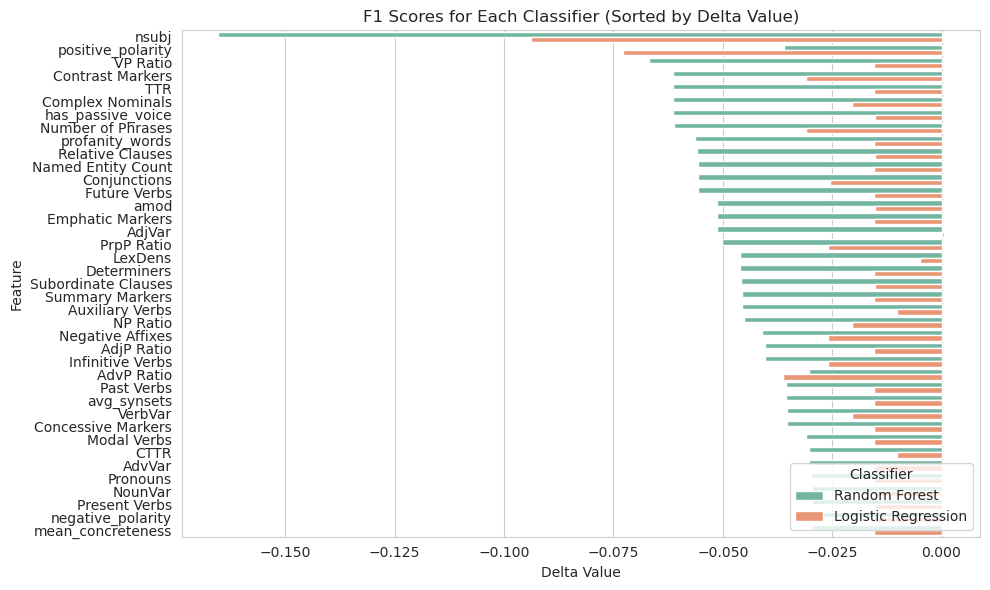

In [114]:
# Sort the features by their delta value in ascending order
df_sorted = df_ablation.sort_values(by='Delta Value', ascending=True)

# Set the style of the plot
sns.set_style("whitegrid")

# Plot the F1 scores for each classifier
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x="Delta Value", y="Feature", hue="Classifier", palette="Set2")
plt.xlabel('Delta Value')
plt.ylabel('Feature')
plt.title('F1 Scores for Each Classifier (Sorted by Delta Value)')
plt.legend(title='Classifier', loc='lower right')

# Adjust spacing between y-axis labels
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.show()

#### C2. Emotion Task

In [115]:
# Split the data into features (X) and target (y)
X_cor_em = data[['LexDens', 'TTR', 'CTTR', 'VerbVar', 'NounVar', 'AdjVar', 'AdvVar', 'profanity_words', 'Conjunctions', 'Pronouns', 'Auxiliary Verbs', 'Modal Verbs', 'Determiners', 'Number of Phrases', 'NP Ratio', 'AdvP Ratio', 'AdjP Ratio', 'PrpP Ratio', 'VP Ratio', 'Complex Nominals', 'Subordinate Clauses', 'Relative Clauses', 'Contrast Markers', 'Emphatic Markers', 'nsubj', 'amod', 'Concessive Markers', 'Summary Markers', 'Negative Affixes', 'Present Verbs', 'Past Verbs', 'Future Verbs', 'Infinitive Verbs', 'has_passive_voice', 'negative_polarity', 'positive_polarity', 'avg_synsets', 'mean_concreteness', 'Named Entity Count']]
y_cor_em = data['Misprediction']

# Split the data into training and testing sets
X_cor_train_em, X_cor_test_em, y_cor_train_em, y_cor_test_em = train_test_split(X_cor_em, y_cor_em, test_size=0.2, random_state=42)

# Initialize Classifiers
model_cor_log_em = LogisticRegression(max_iter=10000) # Create a logistic regression classifier
model_cor_rf_em = RandomForestClassifier() # Create a Random Forest classifier

# Fit the models to the training data
model_cor_log_em.fit(X_cor_train_em, y_cor_train_em) # Logistic regression
model_cor_rf_em.fit(X_cor_train_em, y_cor_train_em) # Random Forest

# Set up k-fold cross-validation for logistic regression
k = 10  # Number of folds
scoring = {'accuracy': make_scorer(accuracy_score), 'f1': make_scorer(f1_score)}
cv_results_log_cor_em = cross_validate(model_cor_log_em, X_cor_train_em, y_cor_train_em, cv=k, scoring=scoring)

# Set up k-fold cross-validation for random forest
cv_results_rf_cor_em = cross_validate(model_cor_rf_em, X_cor_train_em, y_cor_train_em, cv=k, scoring=scoring)

# Extract evaluation metrics from the cross-validation results for logistic regression
cv_accuracy_scores_log_cor_em = cv_results_log_cor_em['test_accuracy']
cv_f1_scores_log_cor_em = cv_results_log_cor_em['test_f1']

# Extract evaluation metrics from the cross-validation results for random forest
cv_accuracy_scores_rf_cor_em = cv_results_rf_cor_em['test_accuracy']
cv_f1_scores_rf_cor_em = cv_results_rf_cor_em['test_f1']

# Calculate evaluation metrics for logistic regression on the test set
precision_log_cor_em = precision_score(y_cor_test_em, model_cor_log_em.predict(X_cor_test_em))
recall_log_cor_em = recall_score(y_cor_test_em, model_cor_log_em.predict(X_cor_test_em))

# Calculate evaluation metric scores for random forest on the test set
precision_rf_cor_em = precision_score(y_cor_test_em, model_cor_rf_em.predict(X_cor_test_em))
recall_rf_cor_em = recall_score(y_cor_test_em, model_cor_rf_em.predict(X_cor_test_em))

# Store the resutls in a new df
results_cor_em = pd.DataFrame({
    'Classifier': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [np.mean(cv_accuracy_scores_log_cor_em), np.mean(cv_accuracy_scores_rf_cor_em)],
    'F1 Score': [np.mean(cv_f1_scores_log_cor_em), np.mean(cv_f1_scores_rf_cor_em)],
    'Precision': [precision_log_cor_em, precision_rf_cor_em],
    'Recall': [recall_log_cor_em, recall_rf_cor_em]
})

# List of feature names
feature_names_em = X_cor_em.columns.tolist()

# Dictionary to store the results
feature_results_em = {}

# Iterate over each feature to ablate
for feature in feature_names_em:
    # Iterate over each classifier
    for classifier, model in zip(['Logistic Regression', 'Random Forest'], [model_cor_log_em, model_cor_rf_em]):
        # Create a new model for each ablated feature
        model = deepcopy(model)
        
        # Check if the feature exists in the input data
        if feature not in X_cor_train_em.columns:
            continue

        # Remove the feature from the input data
        X_train_ablated_em = X_cor_train_em.drop(feature, axis=1)
        X_test_ablated_em = X_cor_test_em.drop(feature, axis=1)

        # Train the model
        model.fit(X_train_ablated_em, y_cor_train_em)

        # Evaluate the model on the test set
        y_pred_em = model.predict(X_test_ablated_em)
        classification_rep_em = classification_report(y_cor_test_em, y_pred_em, output_dict=True)
        f1_measure_em = classification_rep_em['weighted avg']['f1-score']
        delta_value_em = f1_measure_em - results_cor_em.loc[results_cor_em['Classifier'] == classifier, 'F1 Score'].values[0]

        # Store the results
        if feature not in feature_results_em:
            feature_results_em[feature] = {}
        feature_results_em[feature][classifier] = {'F1 Measure': f1_measure_em, 'Delta Value': delta_value_em}

# Create empty lists to store the results
feature_list_em = []
classifier_list_em = []
f1_measure_list_em = []
delta_value_list_em = []

# Iterate over the results dictionary
for feature, classifier_results in feature_results_em.items():
    for classifier, result in classifier_results.items():
        # Append the feature, classifier, F1 measure, and delta value to the respective lists
        feature_list_em.append(feature)
        classifier_list_em.append(classifier)
        f1_measure_list_em.append(result['F1 Measure'])
        delta_value_list_em.append(result['Delta Value'])

# Create a dictionary to store the data
data_feat_abl_em = {
    'Feature': feature_list_em,
    'Classifier': classifier_list_em,
    'F1 Measure': f1_measure_list_em,
    'Delta Value': delta_value_list_em
}

df_ablation_em = pd.DataFrame(data_feat_abl_em)
df_ablation_em

,Feature,Classifier,F1 Measure,Delta Value
0,LexDens,Logistic Regression,0.748788,-0.004930
1,LexDens,Random Forest,0.763907,-0.033426
2,TTR,Logistic Regression,0.738320,-0.015397
3,TTR,Random Forest,0.737832,-0.059501
4,CTTR,Logistic Regression,0.743638,-0.010079
...,...,...,...,...
73,avg_synsets,Random Forest,0.764178,-0.033155
74,mean_concreteness,Logistic Regression,0.738320,-0.015397
75,mean_concreteness,Random Forest,0.743216,-0.054116
76,Named Entity Count,Logistic Regression,0.738320,-0.015397


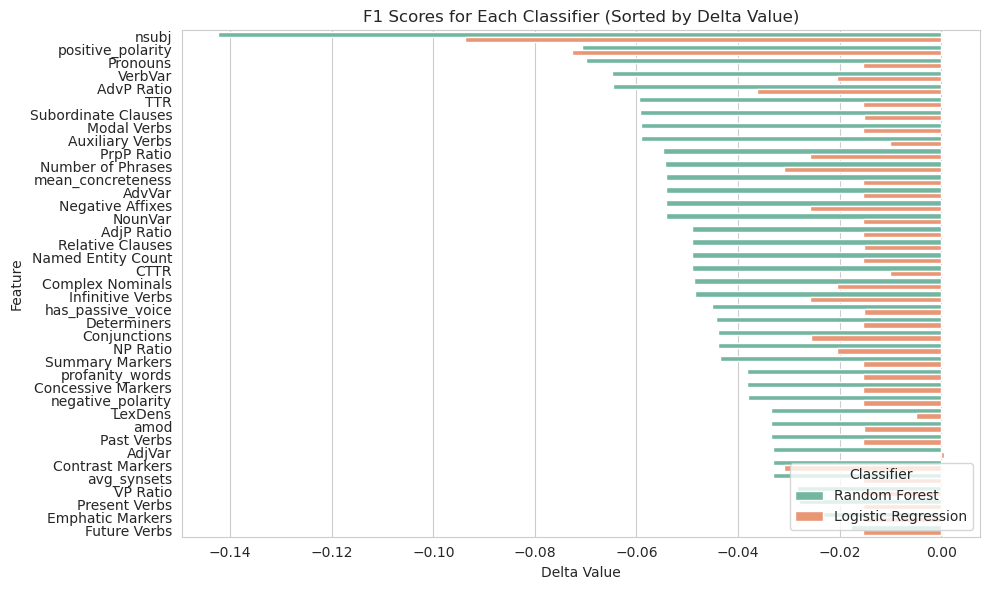

In [116]:
# Sort the features by their delta value in ascending order
df_sorted_em = df_ablation_em.sort_values(by='Delta Value', ascending=True)

# Set the style of the plot
sns.set_style("whitegrid")

# Plot the F1 scores for each classifier
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted_em, x="Delta Value", y="Feature", hue="Classifier", palette="Set2")
plt.xlabel('Delta Value')
plt.ylabel('Feature')
plt.title('F1 Scores for Each Classifier (Sorted by Delta Value)')
plt.legend(title='Classifier', loc='lower right')

# Adjust spacing between y-axis labels
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()
plt.show()

# PART 8: 
## INSIGHTS INTO MODEL'S UNCERTAINTY
### Linear Regression
#### 8.1) Sentiment Analysis Task

In [117]:
# Extract only the mispredicted examples (labeled with 1)
df_prob = data[data['Misprediction'] == 1]

# Specify specific features from df_prob
X = df_prob[['Relative Clauses', 'Contrast Markers','CTTR', 'Number of Phrases','nsubj', 'amod', 'VP Ratio', 'LexDens', 'TTR']]

y = df_prob['Probability']

# Create a linear regression model
model = LinearRegression()

# Fit the linear regression model to the training data
model.fit(X, y)

# Extract the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.00660601  0.00952832 -0.0081032  -0.00715402 -0.00615197  0.00123821
 -0.00283109 -0.00442847 -0.01352457]
Intercept: 0.9020040293398712


In [118]:
# Add a constant column to the feature matrix
X = sm.add_constant(X)

# Create a model
model = sm.OLS(y, X)

# Fit the model to the data
results = model.fit()

# Print the summary report
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Probability   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7252
Date:                Wed, 09 Aug 2023   Prob (F-statistic):              0.686
Time:                        21:39:45   Log-Likelihood:                 303.75
No. Observations:                 478   AIC:                            -587.5
Df Residuals:                     468   BIC:                            -545.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.9020      0.00

#### 8.2) Emotion Analysis Task

In [119]:
# Extract only the mispredicted examples (labeled with 1) from df_prob_em
df_prob_em = data_em[data_em['Misprediction'] == 1]

# Specify specific features from df_prob_em
X_em = df_prob_em[['negative_polarity','VerbVar', 'NounVar', 'Past Verbs', 'PrpP Ratio', 'AdvP Ratio','avg_synsets', 'nsubj', 'amod']]

y_em = df_prob_em['Probability']

# Create an instance of LinearRegression
model_em = LinearRegression()

# Fit the model to the training data
model_em.fit(X_em, y_em)

# Extract the coefficients and intercept
coefficients_em = model_em.coef_
intercept_em = model_em.intercept_

# Print the coefficients and intercept
print("Coefficients:", coefficients_em)
print("Intercept:", intercept_em)

Coefficients: [ 0.02561358 -0.0067395  -0.02681718 -0.00419656  0.00063011 -0.00806145
  0.00538719  0.00046674  0.01221223]
Intercept: 0.817041439388695


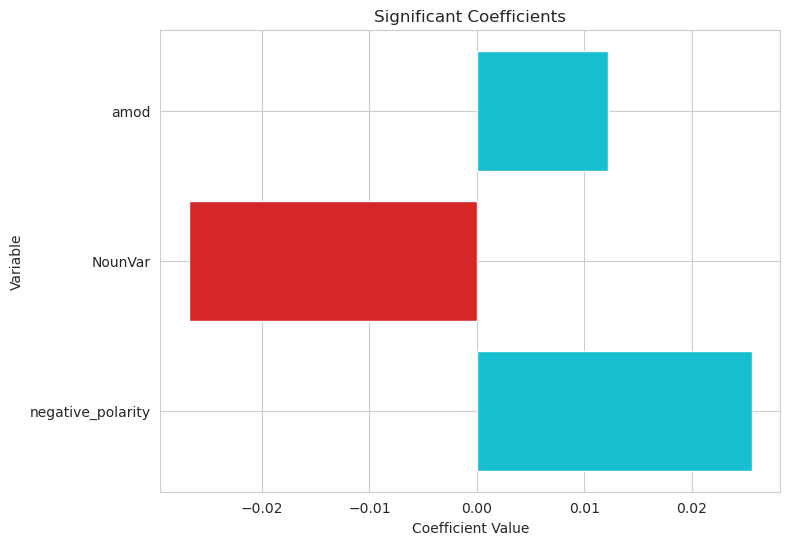

In [120]:
# Fit the linear regression model
X_em = sm.add_constant(X_em)
model_em = sm.OLS(y_em, X_em)
results_em = model_em.fit()

# Extract significant coefficients
significant_coeffs_em = results_em.params[results_em.pvalues < 0.05]

# Exclude the constant term from the plot
significant_coeffs_em = significant_coeffs_em[1:]

# Determine colors based on coefficient direction
colors = ['tab:red' if c < 0 else 'tab:cyan' for c in significant_coeffs_em]

# Plot significant coefficients with colors
plt.figure(figsize=(8, 6))
plt.barh(significant_coeffs_em.index, significant_coeffs_em.values, color=colors)
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Significant Coefficients')
plt.show()

# PART 9: 
## IMPROVING MODEL'S ACCURACY
#### 9.1) Sentiment Analysis Task

In [121]:
# List of words to remove
words_to_remove = ['however', 'nevertheless', 'yet', 'in contrast',
                   'despite', 'although', 'even though', 'but']

# Function for removing the specified contrast markers using regex
def remove_words(text):
    for word in words_to_remove:
        pattern = r'\b' + re.escape(word) + r'\b'  # Create regex pattern with word boundaries
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)  # Remove the word from the text
    return text

#### 9.2) Emotion Analysis Task

In [122]:
# Function for substituting nouns with their most basic sysnonym in WordNet
def substitute_words_with_easier(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    modified_tokens = []
    for token, pos in pos_tags:
        if pos.startswith('NN'):
            synsets = wordnet.synsets(token, pos='n')
            if synsets:
                easy_word = synsets[0].lemmas()[0].name()
                modified_tokens.append(easy_word)
            else:
                modified_tokens.append(token)
        elif pos.startswith('VB'):
            synsets = wordnet.synsets(token, pos='v')
            if synsets:
                easy_word = synsets[0].lemmas()[0].name()
                modified_tokens.append(easy_word)
            else:
                modified_tokens.append(token)
        else:
            modified_tokens.append(token)
    
    modified_text = ' '.join(modified_tokens)
    return modified_text